来源：https://geographicdata.science/book/intro.html


# 空间回归

回归（以及更一般的预测）为我们提供了一个完美的案例来研究空间结构如何帮助我们理解和分析数据。在本章中，我们讨论了如何使用空间结构来验证和改进预测算法，特别关注线性回归。

## *什么是*空间回归以及*为什么*我应该关心它？

通常，空间结构以两种方式之一帮助回归模型。
空间对我们的数据产生影响的第一个（也是最明显的）方式是当*生成*数据的过程本身明确是空间的时。
在这里，想想单户住宅的价格。
通常情况下，个人会支付更高的房价，以便住在更好的学区，获得同样质量的房子。
或者，靠近噪音或化学污染物（如废水处理厂、回收设施或宽阔的高速公路）的房屋实际上可能比我们预期的更便宜。
在哮喘发病率等情况下，个人在一天中倾向于前往的地点（例如他们的工作或娱乐场所）可能比他们的居住地址对他们的健康影响更大。
在这种情况下，可能需要使用*来自其他站点*的数据来预测给定站点的哮喘发病率。
无论具体情况如何，*地理是一个特征*：它直接帮助我们预测结果*因为这些结果是从地理过程获得的*。

另一种选择（和更怀疑的理解）勉强承认地理的工具价值。
通常，在预测方法和分类器的分析中，我们感兴趣的是分析我们犯了什么错误。
这在计量经济学中很常见；分析师可能会担心模型*系统地*错误预测某些类型的观察结果。
如果我们知道我们的模型在已知的一组观察结果或输入类型上通常表现不佳，如果我们可以解释这一点，我们可能会建立一个更好的模型。
在其他类型的错误诊断中，地理为我们提供了一个非常有用的嵌入来评估我们错误的结构。
映射分类/预测错误可以帮助显示我们的数据中是否存在*错误集群*。
如果我们*知道*某些区域的误差往往比其他区域的误差更大（或者如果误差在观察之间“传染”），那么我们可能能够利用这种结构做出更好的预测。

我们的错误中的空间结构可能来自地理*应该*以某种方式成为属性，但我们不确定如何将其包含在我们的模型中。
它们也可能出现，因为有某些*其他*特征的遗漏导致了我们看到的错误中的空间模式；如果包括这个额外的特征，结构就会消失。
或者，它可能来自我们选择用作预测因子的特征之间的复杂相互作用和相互依赖性，导致错误预测的内在结构。
我们在社会过程模型中使用的大多数预测因子都包含*具体化*的空间信息：我们在模型中免费获得的特征所固有的模式。
无论我们有意或无意，在模型中使用空间模式预测因子都可能导致空间模式错误；使用多个预测因子会放大这种影响。
因此，*无论真实过程是否明确是地理的*，关于我们观察结果之间的空间关系的附加信息或有关附近地点的更多信息都可以使我们的预测更好。

在本章中，我们将空间构建到传统的回归框架中。我们从一个没有任何地理参考的标准线性回归模型开始。从那里，我们以三种主要方式形式化空间和空间关系：首先，将其编码为外生变量；第二，通过空间异质性，或作为跨空间结果的系统变化；第三，作为依赖性，或通过与空间邻居特征相关的影响。自始至终，我们关注每种方法所涉及的概念差异，而不是技术细节。

In [2]:
from pysal.lib import weights
from pysal.explore import esda
import numpy
import pandas
import geopandas
import matplotlib.pyplot as plt
import seaborn
import contextily

## 数据：圣地亚哥 Airbnb

为了进一步了解回归的工作原理，我们将研究加利福尼亚州圣地亚哥的 Airbnb 房产信息。
该数据集包含房屋固有特征，既有连续特征（床位数，如 `beds`），也有分类特征（出租类型，或者，在 Airbnb 术语中，房产组，如 `pg_X` 二进制变量系列），也有明确指代数据集位置和空间配置的变量（例如，到巴尔博亚公园的距离，`d2balboa` 或街区 ID，`neighborhood_cleansed`）。

In [3]:
db = geopandas.read_file("../data/airbnb/regression_db.geojson")

这些是我们将在整个章节中使用的解释变量。

In [4]:
variable_names = [
    "accommodates",  # Number of people it accommodates
    "bathrooms",  # Number of bathrooms
    "bedrooms",  # Number of bedrooms
    "beds",  # Number of beds
    # Below are binary variables, 1 True, 0 False
    "rt_Private_room",  # Room type: private room
    "rt_Shared_room",  # Room type: shared room
    "pg_Condominium",  # Property group: condo
    "pg_House",  # Property group: house
    "pg_Other",  # Property group: other
    "pg_Townhouse",  # Property group: townhouse
]

## 非空间回归，（非常）快速回顾

在我们讨论如何将空间明确地纳入线性回归框架之前，让我们展示如何在 Python 中执行基本回归，以及如何开始解释结果。这绝不是回归的正式和完整介绍，因此，如果您正在寻找回归，我们推荐`Gelman_2006`，特别是第 3 章和第 4 章，它们提供了精彩的非空间介绍。

线性回归的核心思想是将给定（*因变量*）变量的变化解释为其他（*解释性*）变量集合的线性函数。例如，在我们的例子中，我们可能希望将房屋的价格表示为其卧室数量和是否为公寓的函数。在个人层面，我们可以将其表达为：

$$
P_i = \alpha + \sum_k \mathbf{X}_{ik}\beta_k + \epsilon_i
$$

其中 $P_i$ 是房屋 $i$ 的 Airbnb 价格，$X$ 是我们用来解释该价格的一组协变量（例如，卧室数量和公寓二元变量）。$\beta$ 是一个参数向量，它为我们提供了有关每个变量与价格的关系方式和程度的信息，常数项 $\alpha$ 是所有其他变量为零时的平均房价。术语 $\epsilon_i$ 通常称为“误差”，它捕获影响房价但不包含在 $X$ 中的因素。我们还可以用矩阵形式来表达这种关系，不包括 $i$ 的子索引，结果如下：

$$
P = \alpha + \mathbf{X}\beta + \epsilon
$$

回归可以看作是双变量相关的多变量扩展。事实上，解释上述方程中 $\beta_k$ 系数的一种方法是将其解释变量 $k$ 与因变量之间的相关度，*保持所有其他解释变量不变*。当计算双变量相关性时，变量的系数会拾取变量之间的相关性，但它也会将与其他相关变量相关的变化纳入其中——也称为混杂因素。一旦我们*控制*了其他变量，回归就可以让我们分离出单个变量对因变量的不同影响。

实际上，Python 中的线性回归相当精简且易于使用。还有几个包可以运行它们（例如，`statsmodels`、`scikit-learn`、`pysal`）。我们将在 Pysal 中导入 `spreg` 模块：

In [5]:
from pysal.model import spreg

在本章的上下文中，从“spreg”开始是有意义的，因为这是唯一允许我们进入明确空间计量经济学模型的库。为了使用普通最小二乘法 (OLS) 拟合上面方程中指定的模型（以 $X$ 为定义列表），我们只需要以下代码行：

In [6]:
# Fit OLS model
m1 = spreg.OLS(
    # Dependent variable
    db[["log_price"]].values,
    # Independent variables
    db[variable_names].values,
    # Dependent variable name
    name_y="log_price",
    # Independent variable name
    name_x=variable_names,
)

我们使用命令“OLS”（“spreg”子包的一部分），并指定因变量（价格的对数，因此我们可以用百分比变化来解释结果）和解释变量。请注意，两个对象都需要是数组，因此我们使用“.values”从“pandas.DataFrame”对象中提取它们。

为了检查模型的结果，我们可以打印“summary”属性：

In [7]:
print(m1.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :   log_price                Number of Observations:        6110
Mean dependent var  :      4.9958                Number of Variables   :          11
S.D. dependent var  :      0.8072                Degrees of Freedom    :        6099
R-squared           :      0.6683
Adjusted R-squared  :      0.6678
Sum squared residual:    1320.148                F-statistic           :   1229.0564
Sigma-square        :       0.216                Prob(F-statistic)     :           0
S.E. of regression  :       0.465                Log likelihood        :   -3988.895
Sigma-square ML     :       0.216                Akaike info criterion :    7999.790
S.E of regression ML:      0.4648                Schwarz criterion     :    8073.685

-----------------------------------------------------------------------------

对输出的完整详细解释超出了本章的范围，因此我们将重点介绍与我们的主要目的相关的部分。这集中在“系数”部分，它为我们提供了模型中 $\beta_k$ 的估计值。换句话说，一旦考虑了混杂因素的影响，这些数字就表达了每个解释变量与因变量之间的关系。但请记住，回归不是魔术；我们只忽略了模型中包含的混杂因素的影响，而不是*所有*潜在的混杂因素的影响。

结果大致符合预期：如果房屋容纳更多人（“容纳”），如果房屋有更多的浴室和卧室，如果房屋是公寓或属于“其他”类别的房屋类型，则房屋往往会更贵。相反，如果房间数量一定，床位较多的房子（即房源更“拥挤”）往往更便宜，因为有些人不租整栋房子，而只租一个房间（`rt_Private_room`）或甚至共享房间（`rt_Shared_room`）。当然，您可能从概念上怀疑可以*任意*更改 Airbnb 内的床位数量而不会最终改变其容纳的人数的假设，但这里不会讨论使用*交互效应*解决这些问题的方法。

### 隐藏结构

总体而言，我们的模型表现良好，能够使用我们上面讨论过的协变量预测平均每晚价格变化的三分之二（$R^2=0.67$）。
但是，我们的模型可能会在错误中显示一些聚类，这可能是一个问题，因为这违反了线性模型通常内置的 i.i.d. 假设。
为了探究这一点，我们可以做几件事。
一个简单的概念可能是查看预测 Airbnb 的误差与预测其最近邻居的误差之间的相关性。
为了检查这一点，我们首先可能希望按地区划分数据，看看我们的残差中是否有某种空间结构。
一个合理的理论可能是我们的模型不包含有关*海滩*的任何信息，而海滩是人们在圣地亚哥生活和度假的一个关键方面。
因此，我们可能想看看我们的错误是否取决于 Airbnb 是否位于“海滩”社区（靠近海洋的社区）。我们使用下面的代码生成图 XXX1XXX，该图查看两组房屋（“海滩”和“无海滩”）之间的价格。

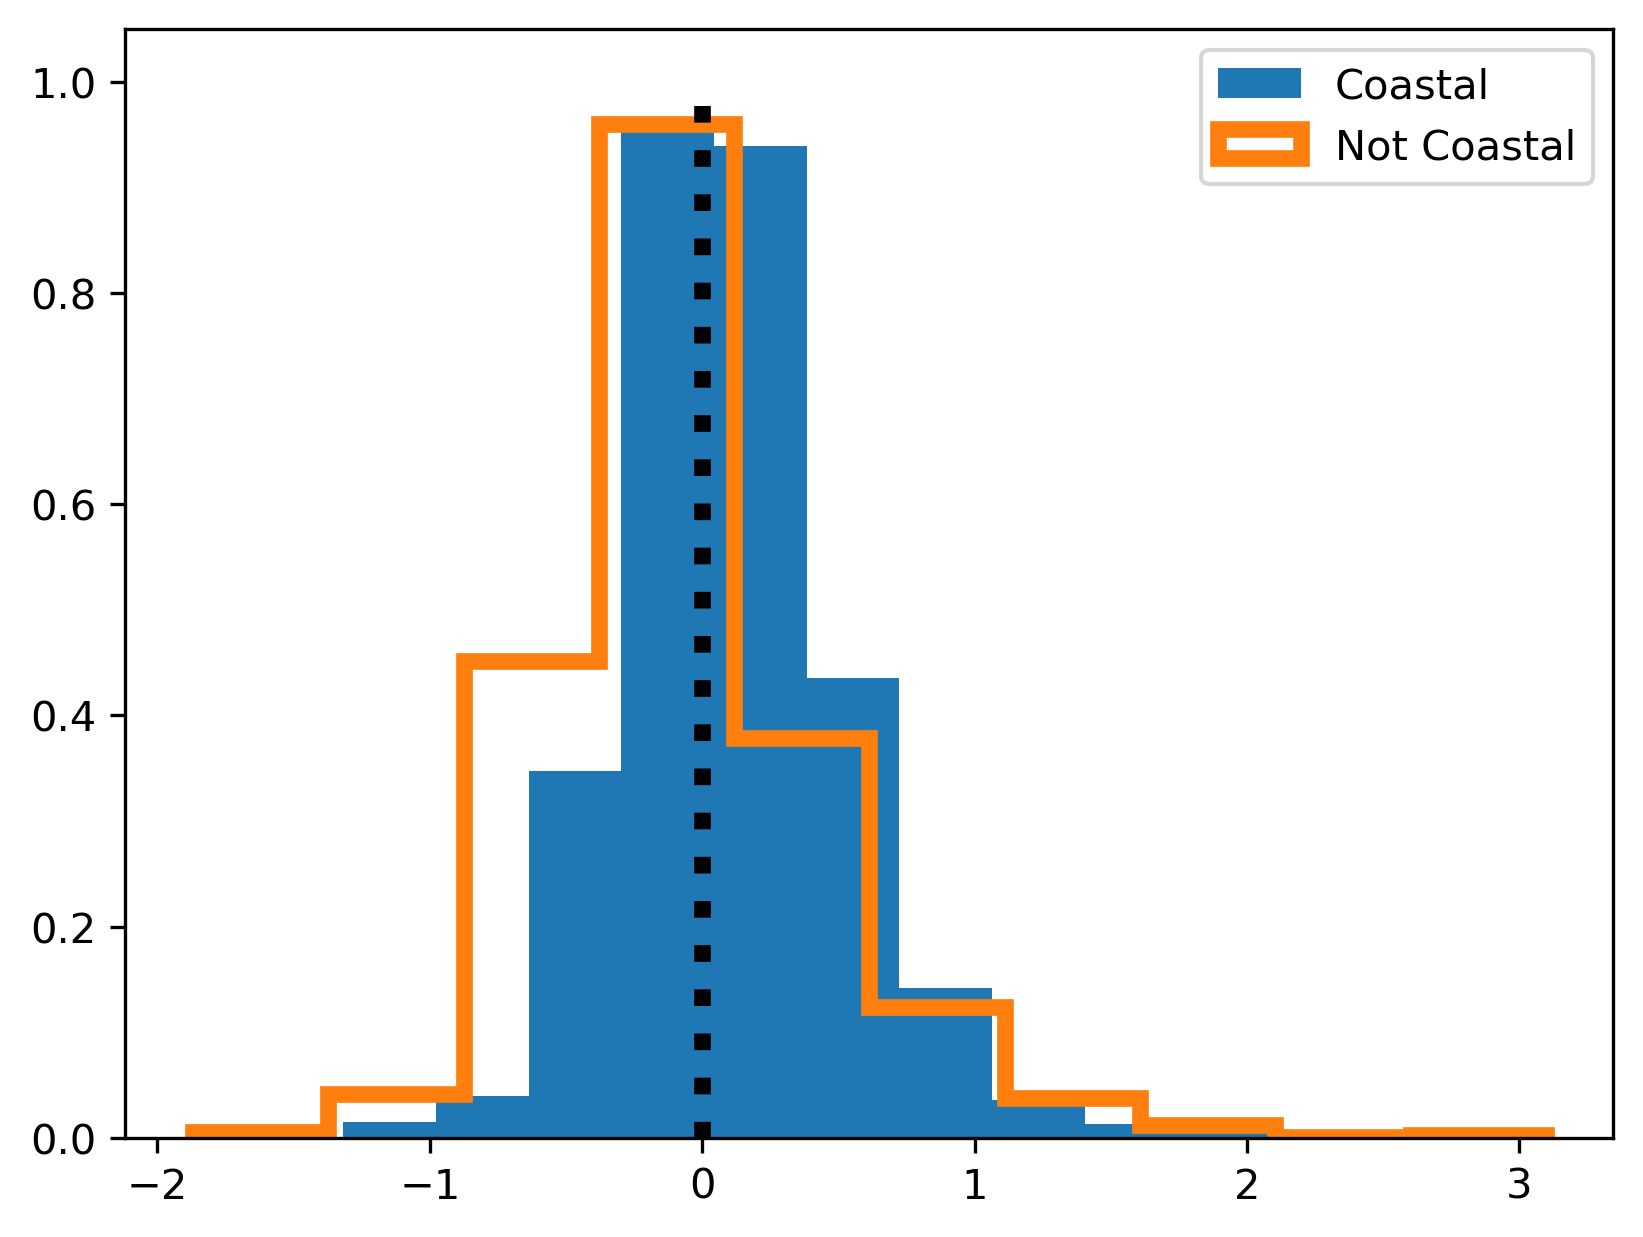

In [8]:
# Create a Boolean (True/False) with whether a
# property is coastal or not
is_coastal = db.coastal.astype(bool)
# Split residuals (m1.u) between coastal and not
coastal = m1.u[is_coastal]
not_coastal = m1.u[~is_coastal]
# Create histogram of the distribution of coastal residuals
plt.hist(coastal, density=True, label="Coastal")
# Create histogram of the distribution of non-coastal residuals
plt.hist(
    not_coastal,
    histtype="step",
    density=True,
    linewidth=4,
    label="Not Coastal",
)
# Add Line on 0
plt.vlines(0, 0, 1, linestyle=":", color="k", linewidth=4)
# Add legend
plt.legend()
# Display
plt.show()

虽然看起来沿海地区的平均误差仅略高一点（并且预测误差的方差较低），但使用经典的 $t$ 检验进行比较时，这两个分布有显著差异：

In [9]:
from scipy.stats import ttest_ind

ttest_ind(coastal, not_coastal)

Ttest_indResult(statistic=array([13.98193858]), pvalue=array([9.442438e-44]))

然而，对于这些数据，可能存在更复杂（也更难欺骗）的测试。我们将在 [挑战](#Challenge) 部分中介绍它们。

此外，由于未建模的潜在偏好或营销，某些社区可能比其他社区更受欢迎。
例如，尽管靠近大海，但居住在彭德尔顿营（城市北部的海军陆战队基地）附近可能会因噪音和污染而对该地区吸引力产生一些重大影响。这些是领域知识提供的问题，数据分析可以帮助我们回答。
为了确定是否是这种情况，我们可能对每个社区内模型残差的完整分布感兴趣。
为了更清楚地说明这一点，我们首先按该社区的中位数残差对数据进行排序，然后制作一个箱线图（图 XXX2XXX），显示每个社区中残差的分布：

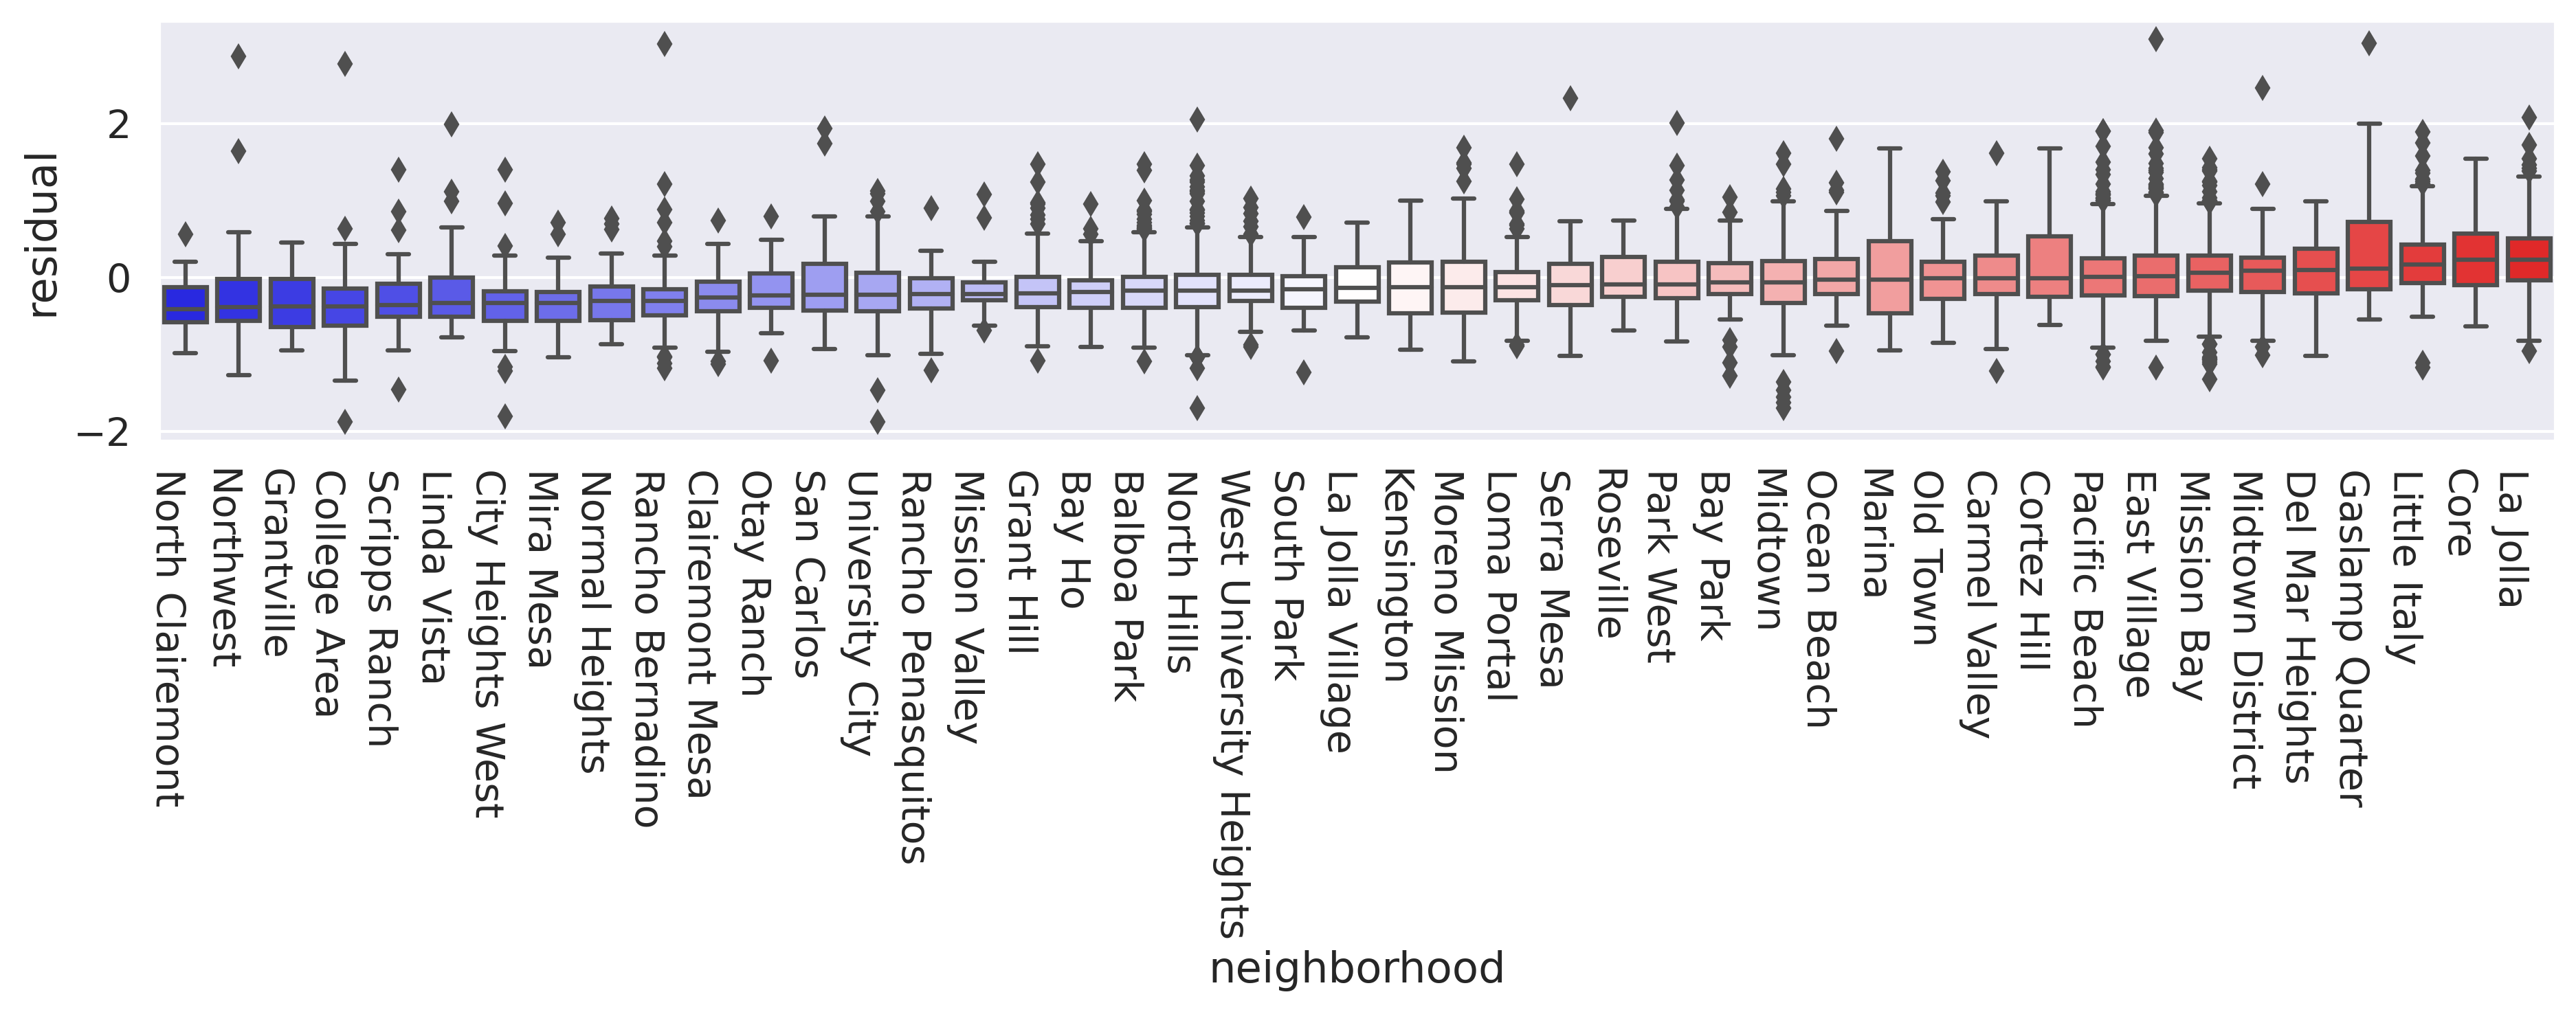

In [10]:
# Create column with residual values from m1
db["residual"] = m1.u
# Obtain the median value of residuals in each neighborhood
medians = (
    db.groupby("neighborhood")
    .residual.median()
    .to_frame("hood_residual")
)

# Increase fontsize
seaborn.set(font_scale=1.25)
# Set up figure
f = plt.figure(figsize=(15, 3))
# Grab figure's axis
ax = plt.gca()
# Generate bloxplot of values by neighborhood
# Note the data includes the median values merged on-the-fly
seaborn.boxplot(
    x="neighborhood",
    y="residual",
    ax=ax,
    data=db.merge(
        medians, how="left", left_on="neighborhood", right_index=True
    ).sort_values("hood_residual"),
    palette="bwr",
)
# Rotate the X labels for legibility
f.autofmt_xdate(rotation=-90)
# Display
plt.show()

没有哪个街区是彼此不相干的，但有些街区确实比其他街区高，例如著名的市中心旅游街区煤气灯街区、小意大利区或核心区。
因此，无形的街区时尚度可能对这个模型产生显著影响。
注意到许多预测过高和预测过低的街区在城市中彼此靠近，夜间租金价格也可能存在某种*传染*或空间溢出效应。
当个人试图为他们的 Airbnb 房源定价以与附近类似的房源竞争时，这种情况通常很明显。
由于我们的模型没有意识到这种行为，因此其错误可能趋于聚集。
我们可以研究这种结构的一个非常简单的方法是检查观察值的残差与其周围残差之间的关系。
为此，我们将使用*空间权重*来表示观察值之间的地理关系。
我们在 [第 4 章](04_spatial_weights) 中详细介绍了空间权重，因此我们在此不再重复。
对于此示例，我们将从 $KNN$ 矩阵开始，其中 $k=1$，这意味着我们只关注每个 Airbnb 与其最近的其他房源之间的联系。

In [11]:
knn = weights.KNN.from_dataframe(db, k=1)

这意味着，当我们计算 $KNN$ 权重和残差的 *空间滞后* 时，我们会得到最接近每个观测值的 Airbnb 列表的残差。

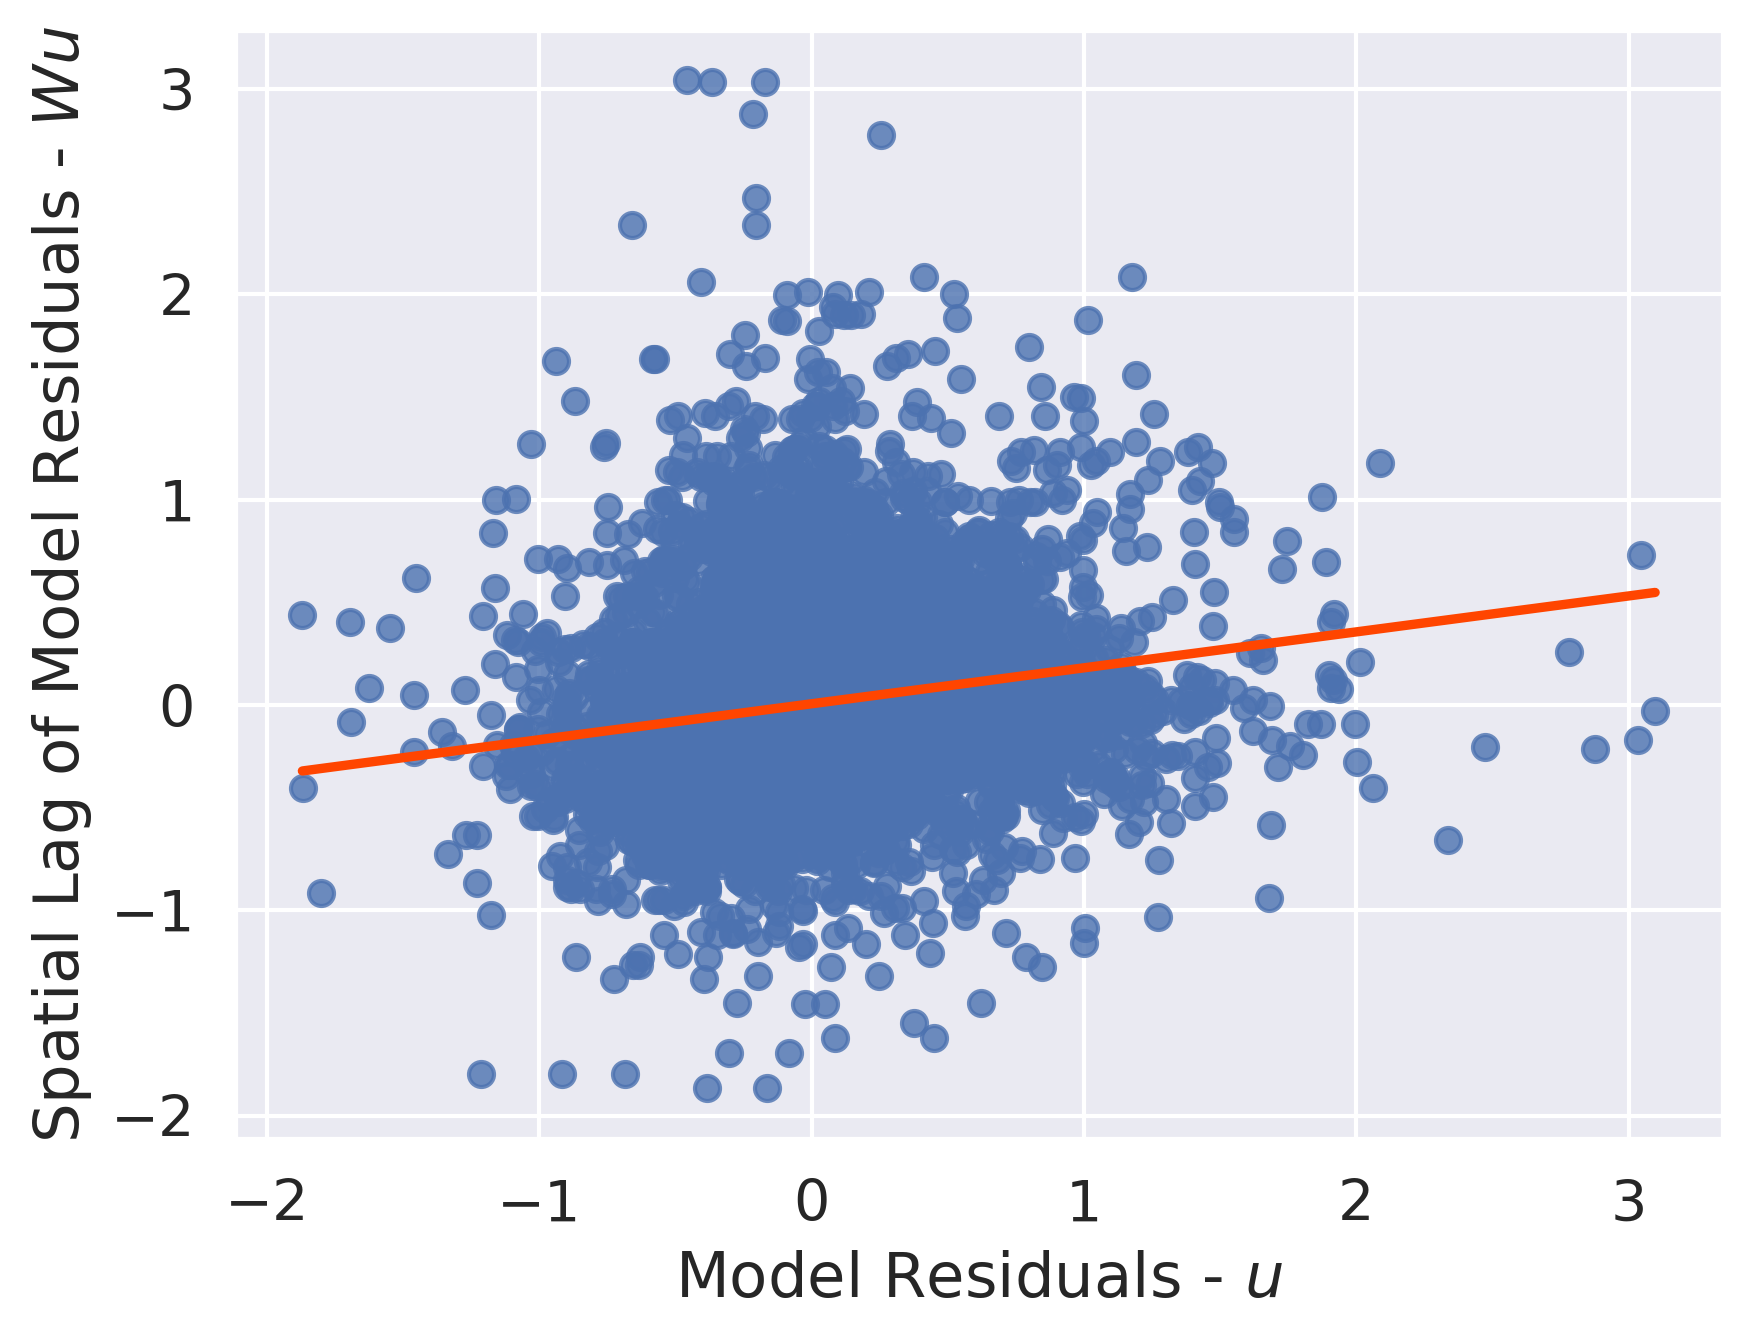

In [12]:
lag_residual = weights.spatial_lag.lag_spatial(knn, m1.u)
ax = seaborn.regplot(
    x=m1.u.flatten(),
    y=lag_residual.flatten(),
    line_kws=dict(color="orangered"),
    ci=None,
)
ax.set_xlabel("Model Residuals - $u$")
ax.set_ylabel("Spatial Lag of Model Residuals - $W u$");

在图 XXX3XXX 中，我们看到我们的预测误差趋于聚集！
上图显示了每个站点的预测误差与最接近该站点的预测误差之间的关系。
在这里，我们使用这个最近的站点来代表该 Airbnb 的 *周围环境*。
这意味着，当模型倾向于过度预测给定 Airbnb 的夜间日志价格时，该 Airbnb 周围的站点也更有可能 *被过度预测*。这种关系的一个有趣特性是，随着用于构建每个 Airbnb 周围环境的最近邻居数量的增加，它趋于稳定。
有关此属性的更多信息，请参阅 [挑战](#Challenge) 部分。

鉴于这种行为，让我们看看稳定的 $k=20$ 个邻居。
检查这个稳定的 *周围环境* 平均值与焦点 Airbnb 之间的关系，我们甚至可以在我们的模型误差中找到聚类。
回顾[第 7 章](07_局部_自相关)中的*局部 Moran*统计数据，图 XXX4XXX 是根据以下代码生成的，用于标识我们对 Airbnb 每晚 (对数) 价格的预测往往存在显著偏差的某些区域：

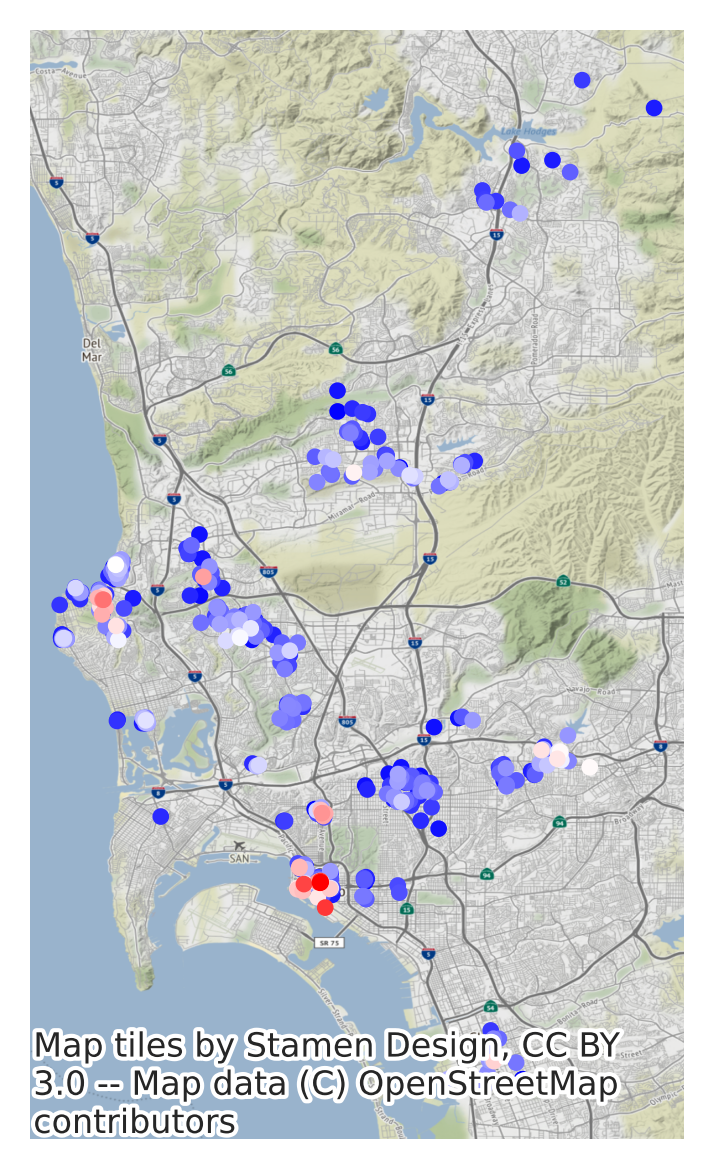

In [13]:
# Re-weight W to 20 nearest neighbors
knn.reweight(k=20, inplace=True)
# Row standardize weights
knn.transform = "R"
# Run LISA on residuals
outliers = esda.moran.Moran_Local(m1.u, knn, permutations=9999)
# Select only LISA cluster cores
error_clusters = outliers.q % 2 == 1
# Filter out non-significant clusters
error_clusters &= outliers.p_sim <= 0.001
# Add `error_clusters` and `local_I` columns
ax = (
    db.assign(
        error_clusters=error_clusters,
        local_I=outliers.Is
        # Retain error clusters only
    )
    .query(
        "error_clusters"
        # Sort by I value to largest plot on top
    )
    .sort_values(
        "local_I"
        # Plot I values
    )
    .plot("local_I", cmap="bwr", marker=".")
)
# Add basemap
contextily.add_basemap(ax, crs=db.crs)
# Remove axes
ax.set_axis_off();

因此，这些区域往往是我们的模型严重低估每晚 Airbnb 价格的位置，无论是针对该特定观察还是其周围环境的观察。
这至关重要，因为如果我们能够确定这些区域的结构——如果它们具有我们可以建模的 *一致地理位置*——那么我们可能会使我们的预测更加准确，或者至少不会系统地错误预测某些区域的价格，而正确预测其他区域的价格。由于严重的低估和高估似乎确实以高度结构化的方式聚集在一起，我们可能能够使用更好的模型来修复模型错误的地理位置。


## 将空间引入回归框架

即使我们并不明确打算研究空间结构，它也会以多种不同的方式出现在我们的模型、预测和数据中。
幸运的是，有几乎同样多的技术，称为*空间回归*方法，专门用于处理这些类型的结构。
空间回归是关于*明确*将空间或地理背景引入回归的统计框架。
从概念上讲，当我们认为空间在我们感兴趣的过程中发挥重要作用时，或者当空间可以作为我们不得不纳入模型的其他因素的合理代理时，我们就想将空间引入我们的模型。
作为前者的一个例子，我们可以想象海滨的房子可能比第二排的房子更贵，因为它们的视野更好。
为了说明后者，我们可以想想社区的特点在决定房价方面的重要性；然而，很难识别和量化“特征”本身，尽管可能更容易获得其空间变化，因此空间作为代理的情况。

空间回归是计量经济学和统计学文献中一个很大的发展领域。
在这个简短的介绍中，我们将考虑两个相关但非常不同的产生空间效应的过程：空间异质性和空间依赖性。在深入研究它们之前，我们先从另一种方法开始，该方法在回归模型中引入空间而不修改模型本身，而是创建空间明确的独立变量。
有关此处介绍的主题的更严格处理，我们建议您参考{cite}`Anselin_2003，Anselin_2014，Gelman_2006`。

### 空间特征工程：邻近变量

使用地理信息“构建”新数据是将空间信息引入数据分析的常用方法。
通常，这反映了这样一个事实：分析地图上的流程并非处处相同，或者地理信息可能有助于预测我们感兴趣的结果。在本节中，我们将简要介绍如何在标准线性模型中插入*空间特征*或由地理关系构建的$X$个变量。不过，我们在[第 12 章](12_feature_engineering)中广泛讨论了空间特征工程，空间特征工程的深度和广度很难被夸大。本节将展示如何将您设计的空间显式变量“插入”到模型中，以提高其性能或帮助您更准确地解释感兴趣的底层过程，而不是详细介绍。

一个可能影响我们圣地亚哥模型的相关邻近驱动变量是基于与巴尔博亚公园的邻近性。巴尔博亚公园是一个常见的旅游目的地，是圣地亚哥市的中心休闲中心，拥有许多博物馆和圣地亚哥动物园。因此，在圣地亚哥寻找 Airbnb 的人可能愿意支付额外费用以住在离公园更近的地方。如果这是真的，并且我们从模型中省略了这一点，我们确实可以看到由这种距离衰减效应引起的显著空间模式。

因此，这有时被称为*空间模式省略的协变量*：我们的模型需要地理信息才能做出良好的预测，而我们却将其从模型中省略了。因此，让我们建立一个包含这个到巴尔博亚公园的距离协变量的新模型。不过，首先，它有助于可视化（图 XXX5XXX）这个距离协变量本身的结构：

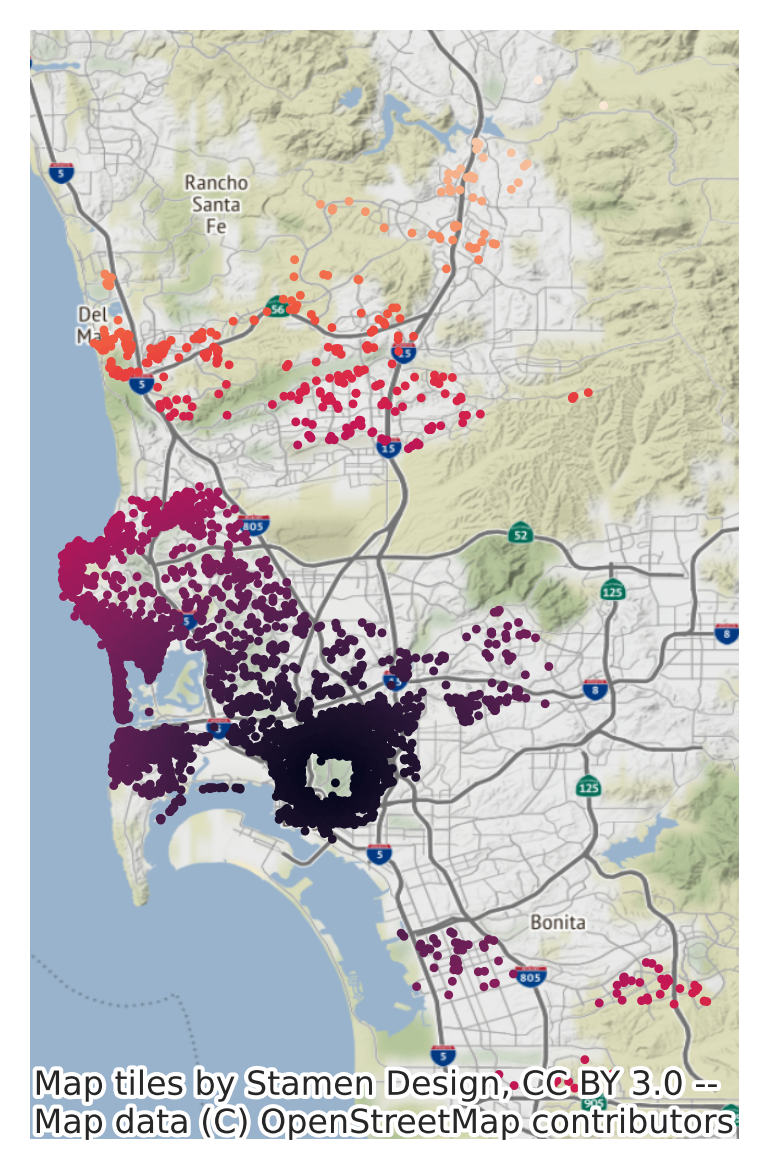

In [14]:
ax = db.plot("d2balboa", marker=".", s=5)
contextily.add_basemap(ax, crs=db.crs)
ax.set_axis_off();

为了运行包含到公园距离的附加变量的线性模型，我们将名称添加到我们最初包含的变量列表中：

In [15]:
balboa_names = variable_names + ["d2balboa"]

然后使用 Pysal 的 `spreg` 中的 OLS 类拟合模型：

In [16]:
m2 = spreg.OLS(
    db[["log_price"]].values,
    db[balboa_names].values,
    name_y="log_price",
    name_x=balboa_names,
)

当您检查回归诊断和输出时，您会发现这个协变量并不像我们预期的那么有用：

In [17]:
pandas.DataFrame(
    [[m1.r2, m1.ar2], [m2.r2, m2.ar2]],
    index=["M1", "M2"],
    columns=["R2", "Adj. R2"],
)

R2   Adj. R2
M1  0.668345  0.667801
M2  0.668502  0.667904

在传统的显著性水平上，它不具有统计学意义，模型拟合度没有实质性变化：

In [18]:
# Set up table of regression coefficients
pandas.DataFrame(
    {
        # Pull out regression coefficients and
        # flatten as they are returned as Nx1 array
        "Coeff.": m2.betas.flatten(),
        # Pull out and flatten standard errors
        "Std. Error": m2.std_err.flatten(),
        # Pull out P-values from t-stat object
        "P-Value": [i[1] for i in m2.t_stat],
    },
    index=m2.name_x,
)

Coeff.  Std. Error        P-Value
CONSTANT         4.379624    0.016915   0.000000e+00
accommodates     0.083644    0.005079   1.156896e-59
bathrooms        0.190791    0.011005   9.120139e-66
bedrooms         0.150746    0.011179   7.418035e-41
beds            -0.041476    0.006939   2.394322e-09
rt_Private_room -0.552996    0.015960  2.680270e-240
rt_Shared_room  -1.235521    0.038462  2.586867e-209
pg_Condominium   0.140459    0.022225   2.803765e-10
pg_House        -0.013302    0.014623   3.630396e-01
pg_Other         0.141176    0.022798   6.309880e-10
pg_Townhouse    -0.045784    0.034356   1.826992e-01
d2balboa         0.001645    0.000967   8.902052e-02

并且，我们的模型错误中似乎仍然存在空间结构，正如我们在下面的代码生成的图 XXX6XXX 中所看到的：

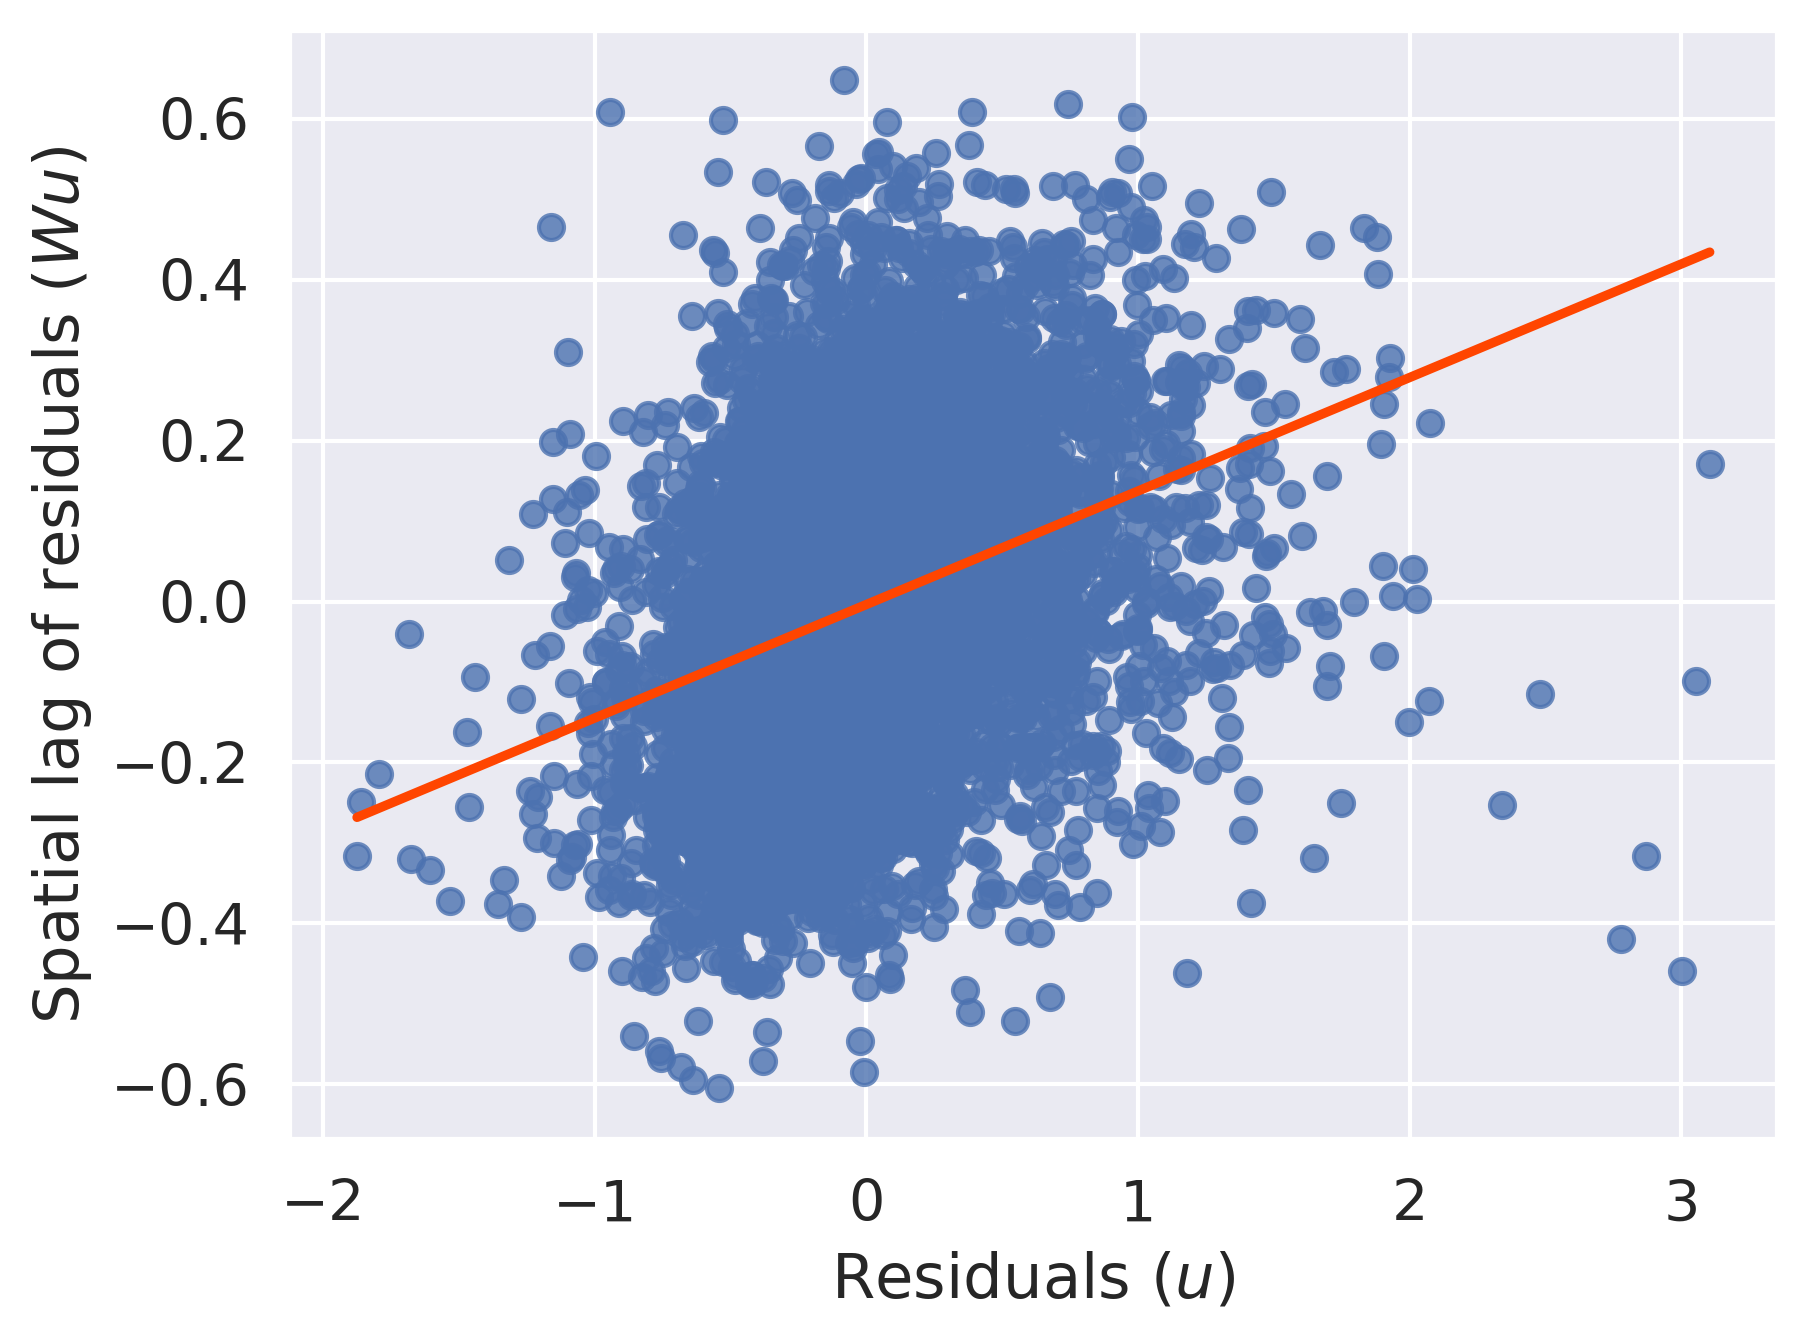

In [19]:
lag_residual = weights.spatial_lag.lag_spatial(knn, m2.u)
ax = seaborn.regplot(
    x=m2.u.flatten(),
    y=lag_residual.flatten(),
    line_kws=dict(color="orangered"),
    ci=None,
)
ax.set_xlabel("Residuals ($u$)")
ax.set_ylabel("Spatial lag of residuals ($Wu$)");

最后，到巴尔博亚公园的距离变量不符合我们关于到便利设施的距离如何影响 Airbnb 价格的理论；系数估计为 *正*，这意味着人们愿意为离巴尔博亚公园 *更远* 而支付额外费用。稍后我们将重新审视这一结果，届时我们将考虑空间异质性并能够对此有所阐释。此外，下一章将广泛讨论空间固定效应，介绍更多空间特征工程方法。在这里，我们仅展示了如何在标准线性建模框架中包含这些工程特征。

### 空间异质性

到目前为止，我们假设我们的接近度变量可能代表个人在靠近休闲区（在本例中为公园）时支付的难以衡量的溢价。在这种情况下，我们的方法是通过一个非常具体的渠道整合空间，即我们认为可能影响最终价格的便利设施的距离。然而，并非所有社区的房价都相同；有些社区可能系统性地比其他社区更贵，无论它们与巴尔博亚公园的距离如何。如果是我们的情况，我们需要某种方法来解释每个社区都可能经历这种 *格式塔* 独特效应的事实。一种方法是捕捉 *空间异质性* (SH)。最基本的是，*空间异质性* 意味着模型的某些部分可能随着地理位置的不同而系统地变化，在不同的地方发生变化。例如，截距 $\alpha$ 的变化可能反映了不同区域对给定过程具有不同的基线暴露这一事实。斜率项 $\beta$ 的变化可能表明某种地理中介因素使得独立变量和因变量之间的关系在空间上发生变化，例如当政府政策在不同司法管辖区之间不一致时。最后，残差方差的变化（通常表示为 $\sigma^2$）可能会引入空间异方差。我们将在本节中处理前两个问题。

#### 空间固定效应

文献通常将 $\alpha$ 的地理变化称为“空间固定效应 (FE)”。为了说明它们，让我们考虑上一节中的房价示例。有时，空间固定效应被称为“空间代理”，因为我们知道结果随空间变化，我们（希望）知道它遵循的模式（在我们的例子中是按邻域），因此我们可以通过让 $\alpha$ 相应地变化将该知识纳入模型。理由如下。鉴于我们只在模型中包含了几个解释变量，我们很可能遗漏了一些在确定房屋售价方面发挥重要作用的重要因素。然而，其中一些因素可能会在空间上系统地变化（例如，不同的社区特征）。如果是这样的话，我们可以通过使用传统的二元变量来控制那些未观察到的因素，但要基于空间规则来创建它们。例如，让我们为每个社区包含一个二元变量，指示给定房屋是否位于该区域内（“1”）或不位于该区域内（“0”）。从数学上讲，我们现在拟合以下等式：

$$
\log{P_i} = \alpha_r + \sum_k \mathbf{X}_{ik}\beta_k + \epsilon_i
$$

其中主要区别在于我们现在允许常数项 $\alpha$ 随社区 $r$ 而变化，即 $\alpha_r$。

以编程方式，我们将展示两种不同的估算方法：一是使用 `statsmodels`；二是使用 `spreg`。首先，我们将使用 `statsmodels`，这是 Python 中的计量经济学家工具箱。

In [20]:
import statsmodels.formula.api as sm

这个包提供了一个类似公式的 API，它允许我们直接表达我们希望估计的*方程*：

In [21]:
f = (
    "log_price ~ "
    + " + ".join(variable_names)
    + " + neighborhood - 1"
)
print(f)

log_price ~ accommodates + bathrooms + bedrooms + beds + rt_Private_room + rt_Shared_room + pg_Condominium + pg_House + pg_Other + pg_Townhouse + neighborhood - 1


此语句中的 *波浪号* 运算符通常读作“对数价格是...的函数”，以说明根据 `log_price` 和我们的协变量列表之间的函数关系可以拟合许多不同的模型规范。至关重要的是，请注意，尾随的 `-1` 项意味着我们在没有截距项的情况下拟合此模型。这是必要的，因为在每个邻域的唯一均值旁边包含一个截距项会使底层方程组不完整。

使用此表达式，我们可以估计每个邻域的独特效果，在 `statsmodels` 中拟合模型（请注意模型、公式和数据的规范如何与拟合步骤分开）：

In [22]:
m3 = sm.ols(f, data=db).fit()

我们可以依靠“summary2()”方法来打印回归中的类似摘要报告，但考虑到本例中报告很长，我们将说明如何将空间固定效应提取到表中进行显示。

In [23]:
# Store variable names for all the spatial fixed effects
sfe_names = [i for i in m3.params.index if "neighborhood[" in i]
# Create table
pandas.DataFrame(
    {
        "Coef.": m3.params[sfe_names],
        "Std. Error": m3.bse[sfe_names],
        "P-Value": m3.pvalues[sfe_names],
    }
)

Coef.  Std. Error  P-Value
neighborhood[Balboa Park]              4.280766    0.033292      0.0
neighborhood[Bay Ho]                   4.198251    0.076878      0.0
neighborhood[Bay Park]                 4.329223    0.050987      0.0
neighborhood[Carmel Valley]            4.389261    0.056553      0.0
neighborhood[City Heights West]        4.053518    0.058378      0.0
neighborhood[Clairemont Mesa]          4.095259    0.047699      0.0
neighborhood[College Area]             4.033697    0.058258      0.0
neighborhood[Core]                     4.726186    0.052643      0.0
neighborhood[Cortez Hill]              4.608090    0.051526      0.0
neighborhood[Del Mar Heights]          4.496910    0.054337      0.0
neighborhood[East Village]             4.545469    0.029373      0.0
neighborhood[Gaslamp Quarter]          4.775799    0.047304      0.0
neighborhood[Grant Hill]               4.306742    0.052365      0.0
neighborhood[Grantville]               4.053298    0.071396      0.0
neighborhood[Kensington]               4.302671    0.077176      0.0
neighborhood[La Jolla]                 4.682084    0.025809      0.0
neighborhood[La Jolla Village]         4.330311    0.077237      0.0
neighborhood[Linda Vista]              4.191149    0.056916      0.0
neighborhood[Little Italy]             4.666742    0.046838      0.0
neighborhood[Loma Portal]              4.301909    0.033236      0.0
neighborhood[Marina]                   4.558298    0.047994      0.0
neighborhood[Midtown]                  4.366661    0.028394      0.0
neighborhood[Midtown District]         4.584938    0.065087      0.0
neighborhood[Mira Mesa]                3.989562    0.056101      0.0
neighborhood[Mission Bay]              4.515479    0.022422      0.0
neighborhood[Mission Valley]           4.275960    0.074231      0.0
neighborhood[Moreno Mission]           4.400942    0.056730      0.0
neighborhood[Normal Heights]           4.097400    0.049022      0.0
neighborhood[North Clairemont]         3.984440    0.069149      0.0
neighborhood[North Hills]              4.253425    0.025478      0.0
neighborhood[Northwest]                4.173752    0.069728      0.0
neighborhood[Ocean Beach]              4.437164    0.030088      0.0
neighborhood[Old Town]                 4.420160    0.041893      0.0
neighborhood[Otay Ranch]               4.185941    0.081597      0.0
neighborhood[Pacific Beach]            4.438829    0.022417      0.0
neighborhood[Park West]                4.440907    0.044768      0.0
neighborhood[Rancho Bernadino]         4.180906    0.072010      0.0
neighborhood[Rancho Penasquitos]       4.162428    0.061776      0.0
neighborhood[Roseville]                4.386992    0.058623      0.0
neighborhood[San Carlos]               4.334991    0.083040      0.0
neighborhood[Scripps Ranch]            4.082380    0.076244      0.0
neighborhood[Serra Mesa]               4.312967    0.059925      0.0
neighborhood[South Park]               4.225311    0.053643      0.0
neighborhood[University City]          4.193718    0.036965      0.0
neighborhood[West University Heights]  4.297672    0.043134      0.0

上述方法显示了空间 FE 是具有分类变量的线性回归的一个特例。邻域成员资格使用二进制虚拟变量建模。得益于 `statsmodels` 中使用的公式语法，我们可以抽象地表达模型，Python 会对其进行解析，并根据需要适当地创建二进制变量。

第二种方法利用了 `spreg` 制度功能。我们将在下面看到制度，但现在，将它们视为空间固定效应的泛化，其中不仅 $\alpha$ 可以变化。该框架允许用户指定要为每个组分别估计哪些变量。在这种情况下，我们不需要用公式描述模型，而是需要将模型的每个元素作为单独的参数传递。

In [24]:
# spreg spatial fixed effect implementation
m4 = spreg.OLS_Regimes(
    # Dependent variable
    db[["log_price"]].values,
    # Independent variables
    db[variable_names].values,
    # Variable specifying neighborhood membership
    db["neighborhood"].tolist(),
    # Allow the constant term to vary by group/regime
    constant_regi="many",
    # Variables to be allowed to vary (True) or kept
    # constant (False). Here we set all to False
    cols2regi=[False] * len(variable_names),
    # Allow separate sigma coefficients to be estimated
    # by regime (False so a single sigma)
    regime_err_sep=False,
    # Dependent variable name
    name_y="log_price",
    # Independent variables names
    name_x=variable_names,
)

与上述类似，我们可以依靠“summary”属性来打印一份包含所有计算结果的报告。为简单起见，我们只确认估计到小数点后 12 位的参数确实与我们从“statsmodels”中获得的参数相同：

In [25]:
import numpy

numpy.round(m4.betas.flatten() - m3.params.values, decimals=12)

array([ 0.e+00, -0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,
        0.e+00,  0.e+00, -1.e-12,  0.e+00,  0.e+00,  0.e+00,  0.e+00,
        0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,
        0.e+00,  0.e+00,  0.e+00, -0.e+00,  0.e+00,  0.e+00,  0.e+00,
        0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,
        0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,
        0.e+00,  0.e+00,  0.e+00,  0.e+00, -0.e+00, -0.e+00,  0.e+00,
       -0.e+00, -0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00])

从计量经济学的角度来说，我们引入的邻里 FE 意味着，我们不会将圣地亚哥的所有房价视为均等，而是仅从每个邮政编码中得出差异。请记住，$\beta_k$ 的解释是变量 $k$ 的影响，*假设所有其他解释变量保持不变*。通过为每个区域包含一个变量，我们实际上迫使模型仅将每个变量具有相同值的房价视为均等；或者换句话说，仅将位于同一区域内的房屋视为均等。引入 FE 可以更高程度地隔离我们在模型中引入的变量的影响，因为我们可以控制与引入的 FE 的分布（在我们的例子中是按邻里）在空间上一致的未观察到的影响。要制作邻里固定效应图，我们需要稍微处理模型的结果。

首先，我们仅提取与邻里相关的影响：

In [26]:
neighborhood_effects = m3.params.filter(like="neighborhood")
neighborhood_effects.head()

neighborhood[Balboa Park]          4.280766
neighborhood[Bay Ho]               4.198251
neighborhood[Bay Park]             4.329223
neighborhood[Carmel Valley]        4.389261
neighborhood[City Heights West]    4.053518
dtype: float64

然后，我们需要从此系列的索引中提取社区名称。一个简单的方法是删除社区名称前后的所有字符：

In [27]:
# Create a sequence with the variable names without
# `neighborhood[` and `]`
stripped = neighborhood_effects.index.str.strip(
    "neighborhood["
).str.strip("]")
# Reindex the neighborhood_effects Series on clean names
neighborhood_effects.index = stripped
# Convert Series to DataFrame
neighborhood_effects = neighborhood_effects.to_frame("fixed_effect")
# Print top of table
neighborhood_effects.head()

fixed_effect
Balboa Park            4.280766
Bay Ho                 4.198251
Bay Park               4.329223
Carmel Valley          4.389261
City Heights West      4.053518

很好，我们回到原始社区名称。这些名称允许我们将其连接到具有社区边界的辅助文件，该文件以相同的名称进行索引。让我们先读取边界：

In [28]:
sd_path = "../data/airbnb/neighbourhoods.geojson"
neighborhoods = geopandas.read_file(sd_path)

然后我们可以合并空间 FE 并将它们绘制在地图上（图 XXX7XXX）：

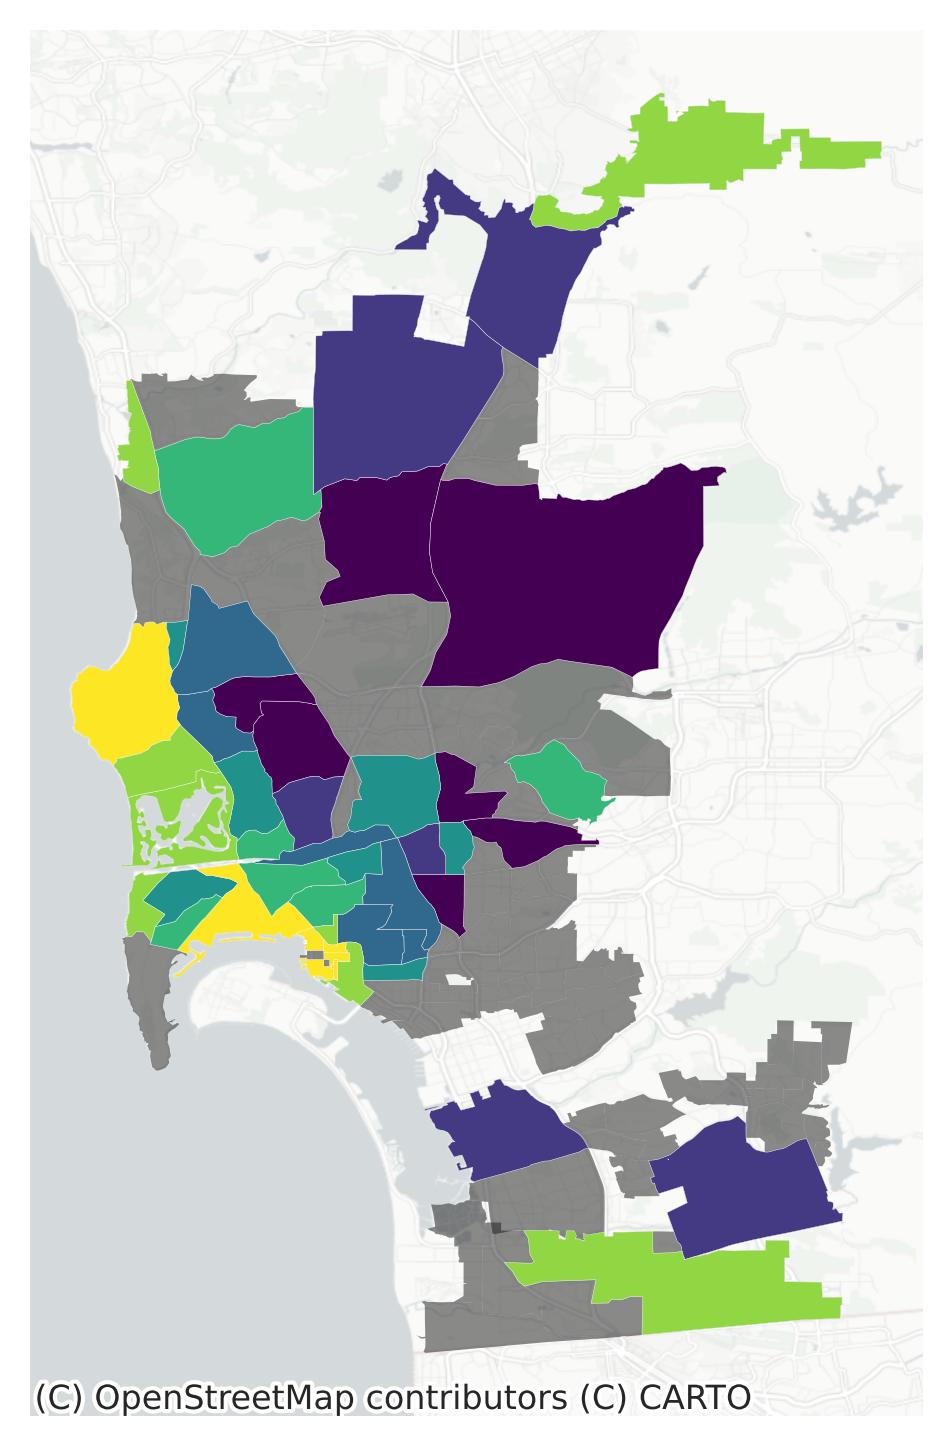

In [29]:
# Plot base layer with all neighborhoods in grey
ax = neighborhoods.plot(
    color="k", linewidth=0, alpha=0.5, figsize=(12, 6)
)
# Merge SFE estimates (note not every polygon
# receives an estimate since not every polygon
# contains Airbnb properties)
neighborhoods.merge(
    neighborhood_effects,
    how="left",
    left_on="neighbourhood",
    right_index=True
    # Drop polygons without a SFE estimate
).dropna(
    subset=["fixed_effect"]
    # Plot quantile choropleth
).plot(
    "fixed_effect",  # Variable to display
    scheme="quantiles",  # Choropleth scheme
    k=7,  # No. of classes in the choropleth
    linewidth=0.1,  # Polygon border width
    cmap="viridis",  # Color scheme
    ax=ax,  # Axis to draw on
)
# Add basemap
contextily.add_basemap(
    ax,
    crs=neighborhoods.crs,
    source=contextily.providers.CartoDB.PositronNoLabels,
)
# Remove axis
ax.set_axis_off()
# Display
plt.show()

我们可以在 SFE 估算中看到清晰的空间结构。最昂贵的社区往往位于海岸附近，而最便宜的社区则位于内陆。

#### 空间制度

估计空间 FE 的核心思想是，不是假设因变量在空间上表现均匀，而是存在影响其行为的地理模式的系统效应。换句话说，空间 FE 在计量经济学上引入了空间异质性的概念。它们以最简单的形式实现这一点：允许常数项在地理上变化。回归的其他元素保持不变，因此在整个空间中均匀应用。空间制度 (SR) 的思想是概括空间 FE 方法，使其不仅允许常数项变化，还允许任何其他解释变量变化。这意味着我们将要估算的方程是：

$$
\log{P_i} = \alpha_r + \sum_k \mathbf{X}_{ki}\beta_{k-r} + \epsilon_i
$$

其中我们不仅允许常数项因地区而异 ($\alpha_r$)，还允许其他每个参数 ($\beta_{k-r}$)。

为了说明这种方法，我们将使用房屋是否位于沿海社区的“空间区分器”（`coastal_neig`）来定义制度。这种选择背后的理由是，租一栋靠近海洋的房子可能具有足够强大的吸引力，人们可能愿意为房屋的每个特征支付不同的*费率*。

为了在 Python 中实现这一点，我们使用 `spreg` 中的 `OLS_Regimes` 类，它为我们完成了大部分繁重的工作：

In [30]:
# Pysal spatial regimes implementation
m5 = spreg.OLS_Regimes(
    # Dependent variable
    db[["log_price"]].values,
    # Independent variables
    db[variable_names].values,
    # Variable specifying neighborhood membership
    db["coastal"].tolist(),
    # Allow the constant term to vary by group/regime
    constant_regi="many",
    # Allow separate sigma coefficients to be estimated
    # by regime (False so a single sigma)
    regime_err_sep=False,
    # Dependent variable name
    name_y="log_price",
    # Independent variables names
    name_x=variable_names,
)

可以像之前一样探索和解释结果。如果检查“summary”属性，您会发现每个变量的参数在两种情况下都基本符合您的预期。为了比较它们，我们可以将它们并排绘制在定制的表格上：

In [31]:
# Results table
res = pandas.DataFrame(
    {
        # Pull out regression coefficients and
        # flatten as they are returned as Nx1 array
        "Coeff.": m5.betas.flatten(),
        # Pull out and flatten standard errors
        "Std. Error": m5.std_err.flatten(),
        # Pull out P-values from t-stat object
        "P-Value": [i[1] for i in m5.t_stat],
    },
    index=m5.name_x,
)
# Coastal regime
## Extract variables for the coastal regime
coastal = [i for i in res.index if "1_" in i]
## Subset results to coastal and remove the 1_ underscore
coastal = res.loc[coastal, :].rename(lambda i: i.replace("1_", ""))
## Build multi-index column names
coastal.columns = pandas.MultiIndex.from_product(
    [["Coastal"], coastal.columns]
)
# Non-coastal model
## Extract variables for the non-coastal regime
ncoastal = [i for i in res.index if "0_" in i]
## Subset results to non-coastal and remove the 0_ underscore
ncoastal = res.loc[ncoastal, :].rename(lambda i: i.replace("0_", ""))
## Build multi-index column names
ncoastal.columns = pandas.MultiIndex.from_product(
    [["Non-coastal"], ncoastal.columns]
)
# Concat both models
pandas.concat([coastal, ncoastal], axis=1)

Coastal                          Non-coastal             \
                   Coeff. Std. Error       P-Value      Coeff. Std. Error   
CONSTANT         4.479904   0.025094  0.000000e+00    4.407242   0.021516   
accommodates     0.048464   0.007881  8.253761e-10    0.090186   0.006474   
bathrooms        0.247478   0.016566  1.381278e-49    0.143376   0.014268   
bedrooms         0.189740   0.017923  5.783965e-26    0.112963   0.013827   
beds            -0.050608   0.010743  2.522348e-06   -0.026272   0.008838   
rt_Private_room -0.558628   0.028312  4.723759e-84   -0.529334   0.018918   
rt_Shared_room  -1.052854   0.084174  1.836512e-35   -1.224459   0.042597   
pg_Condominium   0.204447   0.033943  1.810152e-09    0.105307   0.028131   
pg_House         0.075353   0.023378  1.274269e-03   -0.045447   0.017957   
pg_Other         0.295485   0.038645  2.394157e-14    0.060753   0.027637   
pg_Townhouse    -0.073508   0.049367  1.365396e-01   -0.010397   0.045673   

                                
                       P-Value  
CONSTANT          0.000000e+00  
accommodates      1.893020e-43  
bathrooms         1.418804e-23  
bedrooms          3.731742e-16  
beds              2.964354e-03  
rt_Private_room  3.546091e-162  
rt_Shared_room   1.657163e-170  
pg_Condominium    1.831822e-04  
pg_House          1.140318e-02  
pg_Other          2.796727e-02  
pg_Townhouse      8.199294e-01

围绕制度的相关性出现了一个有趣的问题。*不同制度下每个变量的估计值在统计上是否不同？*为此，模型对象还为我们计算了所谓的 Chow 检验。这是一种统计数据，用于检验零假设，即不同制度的估计值无法区分。如果我们拒绝零假设，则有证据表明制度确实存在差异。

Chow 检验的结果可在 `summary` 属性中找到，也可以直接从模型对象中提取，我们将在此处执行此操作。Chow 检验有两种类型。第一种是全局的，它联合测试两种制度之间的差异：

In [32]:
m5.chow.joint

(328.86902143020575, 7.113548767626822e-64)

第一个值表示统计数据，而第二个值表示 p 值。在这种情况下，两种制度在统计上是不同的。下一步是检查我们模型中的每个系数是否在不同制度之间有所不同。为此，我们可以将它们拉到一个表中：

In [33]:
pandas.DataFrame(
    # Chow results by variable
    m5.chow.regi,
    # Name of variables
    index=m5.name_x_r,
    # Column names
    columns=["Statistic", "P-value"],
)

Statistic       P-value
CONSTANT          4.832180  2.793329e-02
accommodates     16.735685  4.296522e-05
bathrooms        22.671471  1.922004e-06
bedrooms         11.503786  6.945459e-04
beds              3.060313  8.022620e-02
rt_Private_room   0.740097  3.896298e-01
rt_Shared_room    3.308838  6.890820e-02
pg_Condominium    5.057283  2.452265e-02
pg_House         16.792503  4.169771e-05
pg_Other         24.409876  7.786847e-07
pg_Townhouse      0.880564  3.480471e-01

从表中可以看出，从统计学角度来看，大多数变量确实在不同区域存在差异。这表明不同空间区域的数据生成过程存在系统性差异。

### 空间依赖性

正如我们刚刚讨论的那样，SH 是关于与地理*明确相关*的现象的影响，因此会导致空间变化和聚类。这涵盖了我们在拟合线性回归时可能感兴趣的许多类型的空间效应。但是，在其他情况下，我们的重点是观察结果的*空间配置*的影响，以及这种影响对我们正在考虑的结果的影响程度。例如，我们可能认为房屋的价格不仅取决于它是联排别墅还是公寓，还取决于它周围的联排别墅是否比公寓较多的摩天大楼多。我们可以假设，这可能与低矮历史建筑社区与现代高层建筑社区不同的“外观和感觉”有关。就这两种不同的空间配置以不同的方式进入房价确定过程而言，我们不仅有兴趣捕捉房屋的特征，还有兴趣捕捉其周围房屋的特征。这种空间效应与 SH 有根本区别，因为它与地理的固有特征无关，而是与我们数据集中观测值的特征有关，特别是与它们的空间排列有关。我们将这种观测值通过距离相互关联的现象称为“空间依赖性”`Anselin_1988`。

有几种方法可以在计量经济学框架中引入空间依赖性，其计量经济学复杂程度各不相同（请参阅
{cite}`Anselin_2002` 以获得良好的概述）。然而，所有这些方法的共同点是空间的正式封装方式：通过*空间权重矩阵 ($\mathbf{W}$)*，我们在 [第 4 章](04_spatial_weights) 中讨论过。在本节中，我们将考虑三种通过空间权重矩阵将空间依赖性纳入回归框架的方法。我们从“侵入性最小”的方法开始，其中我们只修改独立变量集，然后转向对基线线性模型进行更实质性的修改。

#### 外生效应：SLX 模型

让我们回到我们一直在研究的房价示例。到目前为止，我们假设，通过 Airbnb 在圣地亚哥出租的房屋的价格可以用房屋本身的特征信息以及一些与其位置相关的信息来解释，例如街区或与城市主要公园的距离。但是，也有理由认为，潜在的租客不仅关心房屋本身，还关心房屋的邻居，并且愿意为周围有某些类型房屋的房屋支付更多费用，而如果房屋位于其他类型房屋的中间，则愿意支付更少的费用。我们如何测试这个想法？

当谈到回归时，在数据中的观测值之间引入空间依赖性的最直接方法是不仅考虑给定的解释变量，还考虑其空间滞后。从概念上讲，这种方法更属于空间特征工程的范畴，它通过所使用的解释变量而不是模型的函数形式将空间嵌入模型中，我们将在[第 12 章](12_feature_engineering) 中更详细地探讨这一点。但我们认为在这种情况下讨论它很有趣，原因有二。首先，它提供了“智力支架”，可以学习将空间依赖性构建到回归中的直觉。其次，因为它还说明了我们在[第 12 章](12_feature_engineering) 中介绍的技术有多少可以嵌入到回归模型中（并且，通过扩展，可以嵌入到其他预测方法中）。

在我们的示例中，除了包括房屋类型（`pg_XXX`）的虚拟变量外，我们还可以包含每种房屋类型的空间滞后。这一补充意味着我们还将每种类型的邻近房屋的比例作为给定房屋价​​格的解释因素。从数学上讲，这意味着估计以下模型：

$$
\log(P_i) = \alpha + \sum^{p}_{k=1}X_{ij}\beta_j + \sum^{p}_{k=1}\left(\sum^{N}_{j=1}w_{ij}x_{jk}\right)\gamma_k + \epsilon_i
$$

其中 $\sum_{j=1}^N w_{ij}x_{jk}$ 表示第 $k$ 个解释变量的空间滞后。
这可以用空间权重矩阵 $\mathbf{W}$ 以矩阵形式表示，如下所示：

$$
\log(P_i) = \alpha + \mathbf{X}\beta + \mathbf{WX}\gamma + \epsilon
$$

这将模型拆分为两个主要效应：$\beta$ 和 $\gamma$。
$\beta$ 效应描述了当 $X_{ik}$ 变化一时 $y_i$ 的变化。
[^elast] 站点 $i$ 的下标在这里很重要：因为我们处理的是 $\mathbf{W}$ 矩阵，所以清楚变化发生的位置很有用。

[^elast]：由于我们使用对数价格作为因变量，因此我们的 $\beta$ 系数可以解释为与解释变量单位变化相关的价格百分比变化。

事实上，这对 $\gamma$ 效应很重要，它代表了 $X_i$ 变化与房价之间的 *间接* 关联。这可以用两种方式来概念化。
首先，人们可以将 $\gamma$ 简单地视为 *给定房屋的价格与其平均周围环境的单位变化之间的关联。*
这很有用也很简单。但这种解释模糊了这种变化可能发生的位置。事实上，站点 $i$ 处变量的变化将导致其周围环境的 *溢出*：
当 $x_i$ 发生变化时，任何靠近 $i$ 的站点的 *空间滞后* 也会发生变化。
滞后变化的确切大小将取决于 $\mathbf{W}$ 的结构，并且对于与其连接的每个站点，滞后变化可能不同。例如，想象一个行标准化权重矩阵中高度连接的“焦点”站点。如果邻居改变一个单位，则该焦点站点不会受到强烈影响，因为每个站点仅对焦点站点的滞后产生很小的影响。或者，考虑只有一个邻居的站点：其滞后将改变其唯一邻居改变的量。因此，要发现特定站点 $x_i$ 处的变化引起的变化 $y$ 的确切间接影响，您需要计算 *空间滞后的变化*，然后将其用作 $X$ 的 *变化*。我们将在下一节中讨论这一点。在 Python 中，我们可以计算每个变量的空间滞后，其名称以 `pg_` 开头
首先创建所有这些名称的列表，然后将 `pysal` 的
`lag_spatial` 应用于每个名称：

In [34]:
# Select only columns in `db` containing the keyword `pg_`
wx = (
    db.filter(
        like="pg_"
        # Compute the spatial lag of each of those variables
    )
    .apply(
        lambda y: weights.spatial_lag.lag_spatial(knn, y)
        # Rename the spatial lag, adding w_ to the original name
    )
    .rename(
        columns=lambda c: "w_"
        + c
        # Remove the lag of the binary variable for apartments
    )
    .drop("w_pg_Apartment", axis=1)
)

计算完成后，我们可以使用 OLS 估计来运行模型，因为在这种情况下，所包含的空间滞后不违反 OLS 所依赖的任何假设（它们本质上是额外的外生变量）：

In [35]:
# Merge original variables with the spatial lags in `wx`
slx_exog = db[variable_names].join(wx)
# Fit linear model with `spreg`
m6 = spreg.OLS(
    # Dependent variable
    db[["log_price"]].values,
    # Independent variables
    slx_exog.values,
    # Dependent variable name
    name_y="l_price",
    # Independent variables names
    name_x=slx_exog.columns.tolist(),
)

与前面的情况一样，打印模型对象的“summary”属性将显示完整的报告表。我们在原始回归中包含的变量
表现出类似的行为，尽管大小变化很小，也可以以类似的方式进行解释。为了关注与以前的模型不同的方面，我们将仅提取我们也包括其空间滞后的变量的结果：

In [36]:
# Collect names of variables of interest
vars_of_interest = (
    db[variable_names].filter(like="pg_").join(wx).columns
)
# Build full table of regression coefficients
pandas.DataFrame(
    {
        # Pull out regression coefficients and
        # flatten as they are returned as Nx1 array
        "Coeff.": m6.betas.flatten(),
        # Pull out and flatten standard errors
        "Std. Error": m6.std_err.flatten(),
        # Pull out P-values from t-stat object
        "P-Value": [i[1] for i in m6.t_stat],
    },
    index=m6.name_x
    # Subset for variables of interest only and round to
    # four decimals
).reindex(vars_of_interest).round(4)

Coeff.  Std. Error  P-Value
pg_Condominium    0.1063      0.0222   0.0000
pg_House          0.0328      0.0157   0.0368
pg_Other          0.0862      0.0240   0.0003
pg_Townhouse     -0.0277      0.0338   0.4130
w_pg_Condominium  0.5928      0.0690   0.0000
w_pg_House       -0.0774      0.0319   0.0152
w_pg_Other        0.4851      0.0551   0.0000
w_pg_Townhouse   -0.2724      0.1223   0.0260

每种房产类型的空间滞后（`w_pg_XXX`）是新增的。我们观察到，除了联排别墅的情况（与二元变量`pg_Townhouse`相同），它们都是显著的，这表明我们最初关于周围房屋作用的假设可能确实在这里起作用。

为了举例说明，让我们看看一些直接/间接影响。

`pg_Condominium`变量的直接影响意味着公寓通常比基准房产类型公寓贵 11%（$\beta_{pg\_{Condominium}}=0.1063$）。与本节更相关的是，任何被公寓包围的房屋*也*会获得价格溢价。但是，由于 $pg_{Condominium}$ 是一个虚拟变量，
地点 $i$ 的空间滞后代表 $i$ 附近为公寓的房产的 *百分比*，介于 $0$ 和 $1$ 之间。[^Discover]
因此，此变量的 *单位* 变化意味着您将公寓百分比增加 100%。因此，`w_pg_Condominium` 增加 $.1$（十个百分点的变化）
将导致房价上涨 5.92% ($\beta_{w_pg\_Condominium} = 0.6$)。
可以对所有其他空间滞后变量得出类似的解释，以得出空间滞后变化的 *间接* 影响。

要计算给定地点 $i$ 的间接变化，您可能需要检查其价格的预测值。在这个例子中，由于我们使用了具有 20 个最近邻居的行标准化权重矩阵，因此改变 $x_i$ 对其所有邻居和任何站点 $i$ 的影响都是相同的。因此，效果始终为 $\frac{\gamma}{20}$，或约 $0.0296$。然而，有趣的是，对于许多其他类型的权重（如 `Kernel`、`Queen`、`Rook`、`DistanceBand` 或 `Voronoi`），情况并非如此，其中每个观察值可能具有不同数量的邻居。为了说明这一点，我们将为公寓组中的特定 $i$ 构建间接影响。

首先，$y_i$ 的预测值存储在任何 `spreg` 模型的 `predy` 属性中：

[^Discover]：自己发现：`numpy.array([True, True, True, False, False, True)]` 的平均值是多少？

In [37]:
# Print first three predicted values
m5.predy[:3]

array([[5.27285901],
       [5.39966259],
       [4.28834686]])

要建立新的预测，我们需要遵循模型的基本方程。

为了说明某个位置的某个值的变化对其他位置的影响，我们将其中一个属性转换为公寓类别。考虑第三个观察值，即数据中的第一个公寓：

In [38]:
# Print values for third observation for columns spanning
# from `pg_Apartment` to `pg_Townhouse`
db.loc[2, "pg_Apartment":"pg_Townhouse"]

pg_Apartment      1
pg_Condominium    0
pg_House          0
pg_Other          0
pg_Townhouse      0
Name: 2, dtype: object

现在让我们复制数据并更改其值，以将公寓神奇地变成公寓：

In [39]:
# Make copy of the dataset
db_scenario = db.copy()
# Make Apartment 0 and condo 1 for third observation
db_scenario.loc[2, ["pg_Apartment", "pg_Condominium"]] = [0, 1]

我们已成功完成更改：

In [40]:
db_scenario.loc[2, "pg_Apartment":"pg_Townhouse"]

pg_Apartment      0
pg_Condominium    1
pg_House          0
pg_Other          0
pg_Townhouse      0
Name: 2, dtype: object

现在，我们还需要更新空间滞后变量：

In [41]:
# Select only columns in `db_scenario` containing the keyword `pg_`
wx_scenario = (
    db_scenario.filter(
        like="pg"
        # Compute the spatial lag of each of those variables
    )
    .apply(
        lambda y: weights.spatial_lag.lag_spatial(knn, y)
        # Rename the spatial lag, adding w_ to the original name
    )
    .rename(
        columns=lambda c: "w_"
        + c
        # Remove the lag of the binary variable for apartments
    )
    .drop("w_pg_Apartment", axis=1)
)

并构建一个新的外生 $\mathbf{X}$ 矩阵，其中包含一个常数 1 作为首列

In [42]:
slx_exog_scenario = db_scenario[variable_names].join(wx_scenario)

现在，我们可以通过将模型方程转换成 Python 代码并将我们刚刚创建的模拟值代入其中来计算我们的新预测（在我们将地点“ 2”从公寓改为共管公寓的场景中）：

In [43]:
# Compute new set of predicted values
y_pred_scenario = m6.betas[0] + slx_exog_scenario @ m6.betas[1:]

请注意，这组预测与原始“m6”模型中的预测之间的唯一区别在于，我们将地点“2”从公寓改为共管公寓。因此，与地点“2”不相连（或不是地点“2”本身）的每个房产都不会受到影响。然而，地点“2”的邻居会有不同的预测。为了探索这些，我们首先确定谁属于这一群体：

In [44]:
print(knn.neighbors[2])

[772, 2212, 139, 4653, 2786, 1218, 138, 808, 1480, 4241, 1631, 3617, 2612, 1162, 135, 23, 5528, 3591, 407, 6088]


现在，将地点“ 2”从公寓改为共管公寓的影响与预测价格（对数）的以下变化有关，我们通过从原始值中减去新的预测值并仅对地点“ 2”及其邻居进行子集来计算：

In [45]:
# Difference between original and new predicted values
(
    y_pred_scenario
    - m6.predy
    # Subset to site `2` and its neighbors
).loc[[2] + knn.neighbors[2]]

0
2     0.106349
772   0.029642
2212  0.029642
139   0.029642
4653  0.029642
2786  0.029642
1218  0.029642
138   0.029642
808   0.029642
1480  0.029642
4241  0.029642
1631  0.029642
3617  0.029642
2612  0.029642
1162  0.029642
135   0.029642
23    0.029642
5528  0.029642
3591  0.029642
407   0.029642
6088  0.029642

我们看到第一行代表直接效应，与“pg_Condominium”的估计值完全相等。但是，对于其他影响，我们仅将“w_pg_Condominium”更改了 $.03$，这大致等于边际效应（“w_pg_Condominium”）除以站点“2”与每个邻居之间的空间关系权重（在本例中，每个邻居的权重为 $\frac{1}{20}$，但请注意，如果不同的邻居具有不同的基数，则情况会有所不同）。

正如我们刚刚看到的，引入解释变量的空间滞后是将空间依赖性概念纳入线性回归框架的最直接方法。它不需要额外的更改，可以用 OLS 进行估计，并且解释与解释非空间变量非常相似，只要需要总体变化即可。

然而，空间计量经济学领域要广泛得多，在过去几十年中，已经产生了许多以不同方式处理空间效应和空间依赖性的技术。虽然这可能过于简单化，但可以说，对于单个横截面的情况，大多数此类努力都集中在两个主要变化上：空间滞后和空间误差模型。两者都类似于我们所看到的情况，因为它们是基于引入空间滞后的，但它们在修改和影响的模型组成部分上有所不同。

#### 空间误差

空间误差模型在方程的*误差*项中包含空间滞后：

$$
\log{P_i} = \alpha + \sum_k \beta_k X_{ki} + u_i
$$

$$
u_i = \lambda u_{lag-i} + \epsilon_i
$$

其中 $u_{lag-i} = \sum_j w_{i,j} u_j$。

虽然看起来很相似，但此规范违反了经典 OLS 模型中关于误差项的假设。因此，需要替代估计方法。Pysal 结合了估计空间计量经济学文献中开发的几种最先进的技术的功能。例如，我们可以使用考虑异方差的一般矩法{cite}`arraiz2010`：

In [46]:
# Fit spatial error model with `spreg`
# (GMM estimation allowing for heteroskedasticity)
m7 = spreg.GM_Error_Het(
    # Dependent variable
    db[["log_price"]].values,
    # Independent variables
    db[variable_names].values,
    # Spatial weights matrix
    w=knn,
    # Dependent variable name
    name_y="log_price",
    # Independent variables names
    name_x=variable_names,
)

与之前类似，`summary` 属性将返回一个功能齐全的结果表。在大多数情况下，它的解释方式可能与上述类似。主要区别在于，在这种情况下，我们还可以恢复误差项中 $\lambda$ 参数的估计和推断：

In [47]:
# Build full table of regression coefficients
pandas.DataFrame(
    {
        # Pull out regression coefficients and
        # flatten as they are returned as Nx1 array
        "Coeff.": m7.betas.flatten(),
        # Pull out and flatten standard errors
        "Std. Error": m7.std_err.flatten(),
        # Pull out P-values from t-stat object
        "P-Value": [i[1] for i in m7.z_stat],
    },
    index=m7.name_x
    # Subset for lambda parameter and round to
    # four decimals
).reindex(["lambda"]).round(4)

Coeff.  Std. Error  P-Value
lambda  0.6449      0.0187      0.0

#### 空间滞后

空间滞后模型引入了*因*变量的空间滞后。在我们所介绍的例子中，这将转化为：

$$
\log{P_i} = \alpha + \rho \log{P_{lag-i}} + \sum_k \beta_k X_{ki} + \epsilon_i
$$

虽然看起来与前一个方程没有太大区别，但这个模型违反了外生性假设，而外生性假设对于 OLS 的运作至关重要。
简而言之，当 $P_i$ 存在于等号的“两边”时，就会发生这种情况。
理论上，由于 $P_i$ 包含在计算 $P_{lag-i}$ 中，因此违反了外生性。
与空间误差的情况类似，已经提出了几种技术来克服这一限制，Pysal 实现了其中的几种。在下面的例子中，我们使用两阶段最小二乘估计{cite}`Anselin_1988`，其中所有解释变量的空间滞后被用作内生滞后的工具：

In [48]:
# Fit spatial lag model with `spreg`
# (GMM estimation)
m8 = spreg.GM_Lag(
    # Dependent variable
    db[["log_price"]].values,
    # Independent variables
    db[variable_names].values,
    # Spatial weights matrix
    w=knn,
    # Dependent variable name
    name_y="log_price",
    # Independent variables names
    name_x=variable_names,
)

让我们像前面一样在表格中总结这些系数（适用关于“summary”对象的通常免责声明）：

In [49]:
# Build full table of regression coefficients
pandas.DataFrame(
    {
        # Pull out regression coefficients and
        # flatten as they are returned as Nx1 array
        "Coeff.": m8.betas.flatten(),
        # Pull out and flatten standard errors
        "Std. Error": m8.std_err.flatten(),
        # Pull out P-values from t-stat object
        "P-Value": [i[1] for i in m8.z_stat],
    },
    index=m8.name_z
    # Round to four decimals
).round(4)

Coeff.  Std. Error  P-Value
CONSTANT         2.7440      0.0727   0.0000
accommodates     0.0698      0.0048   0.0000
bathrooms        0.1627      0.0104   0.0000
bedrooms         0.1604      0.0105   0.0000
beds            -0.0365      0.0065   0.0000
rt_Private_room -0.4981      0.0151   0.0000
rt_Shared_room  -1.1157      0.0366   0.0000
pg_Condominium   0.1073      0.0209   0.0000
pg_House        -0.0004      0.0137   0.9766
pg_Other         0.1208      0.0215   0.0000
pg_Townhouse    -0.0186      0.0323   0.5653
W_log_price      0.3416      0.0148   0.0000

与 SLX 回归中的效果类似，空间滞后回归中的变化需要谨慎解释。在这里，`W_log_price` 在所有观测值上一致适用，实际上改变了每个 $\beta$ 系数的有效强度。因此，使用预测和情景构建来预测改变 $X$ 时的 $y$ 很有用，这允许您分析 *直接* 和 *间接* 成分。

#### 将空间引入回归的其他方法

我们在这里仅介绍了在回归框架中正式引入空间的几种方法。然而，在统计、数据科学和应用分析中，还有许多其他常规使用的高级空间回归方法。例如，广义加性模型 {cite}`Gibbons_2015,Wood_2006` 已用于在回归函数中直接应用空间核平滑。其他类似的平滑方法，如空间高斯过程模型 {cite}`Brunsdon_2010` 或克里金法，也将位置之间的依赖关系概念化为平滑。空间回归中考虑基于图形的地理（而不是距离/核效应）的其他方法包括条件自回归模型的变体，该模型检查位置的空间关系*取决于其周围环境*，而不是与周围环境共同出现。然而，尽管{cite}`Banerjee_2008`提供了详细而全面的讨论，但这些主题的全面介绍超出了本书的范围。我们没有介绍这些（和其他现有的），不是因为我们认为它们不重要或无用，远非如此，而是因为我们认为它们比我们想要介绍的章节的水平要高级一些。

我们在这里介绍的两组模型以及我们未介绍的其他现有模型都具有将空间嵌入回归框架中作为“一等”公民的特征。在所有这些情况下，我们概念化空间（例如，通过空间权重矩阵）并修改原始模型的函数形式，以便在生成预测或推断时识别其观测的位置。这种方法会导致对建模框架进行修改以适应地理因素。在下一章中，我们将讨论将空间嵌入建模工作的不同视角。我们不是通过函数形式注入空间，而是通过我们用来解释/预测感兴趣结果的变量来实现。在这种情况下，我们将在数据通过建模框架之前使用地理因素来丰富数据。

## 问题

1. 一种常见的空间计量经济学模型是“空间 Durbin 模型”，它将 SLX 模型与空间滞后模型相结合。或者，“空间 Durbin 误差模型”将 SLX 模型与空间误差模型相结合。拟合我们在本章中拟合的空间模型的空间 Durbin 变体。
- 这些变体是否会改善模型拟合度？
- 当添加 SLX 项时，空间自相关参数 ($\rho$, $\lambda$) 会发生什么？为什么会发生这种情况？
2. 对我们来说幸运的是，空间误差模型恢复的估计值（渐近）与典型的 OLS 估计值相同，尽管它们的置信区间会发生变化。从统计学上讲，这是因为当存在空间相关性和/或空间异方差时，OLS 会计算错误。当空间误差模型拟合时，置信区间会发生多大变化？
3. SLX 模型（和空间 Durbin 变体）的一个常见理由是关于 *省略的、空间模式化的变量*。也就是说，如果省略的变量与包含的变量相关联 *并且* 具有空间模式，那么我们可以使用现有变量的空间结构来模拟省略的变量。在我们的空间滞后模型中，
- 我们可能遗漏了哪些对预测 Airbnb 价格很重要的变量？
- 这些省略的变量是否具有与我们包含的变量相似的空间模式？为什么或为什么不？
4. *空间*回归模型通常关注附近的观测值如何彼此相似，而 *平台*模型关注同一空间组中的观测值如何彼此相似。这些通常使用多级或空间混合效应模型来处理。这两个想法什么时候可以很好地协同工作？什么时候它们可能会不一致？

### 挑战性问题

以下讨论有点挑战性，但反映了对本章讨论的额外增强，可能会巩固或增强对材料的高级理解。

#### 随机海岸
在分析我们的简单模型残差的部分中，我们进行了经典的双样本 $t$ 检验，以确定我们的沿海和非沿海住宅区是否倾向于具有相同的预测误差。不过，通常最好使用直接的、数据驱动的测试和模拟方法，而不是假设满足 $t$ 统计量的数学假设。

为此，我们可以将我们的任务打乱到海岸和非海岸，并检查*观察到的*残差分布和随机分布的分布是否存在差异。通过这种方式，我们打乱了海岸上的观察结果，并绘制了得到的累积分布。

下面，我们运行 100 次模拟重新分配区域到“沿海”或“非沿海”的实验，并将随机分配的残差分布与观察到的残差分布进行比较。此外，我们通过 *经验累积密度函数* 而不是直接通过直方图进行绘制。这是因为 *经验累积密度函数* 通常更容易通过视觉检查，尤其是对于细微的差异。

图 XXX8XXX 中的黑线代表我们的模拟，其下方的彩色斑块代表观察到的残差分布。如果黑线倾向于位于彩色斑块的左侧，那么模拟（其中预测误差对于我们的“沿海”和“非沿海”类别完全是随机的）往往比我们的实际模型具有更多的负残差。如果黑线倾向于在右侧，那么它们往往具有更多的正残差。作为复习，正残差意味着我们的模型预测不足，而负残差意味着我们的模型预测过度。下面，我们的模拟为我们的模型可能系统地低估沿海价格并高估非沿海价格的说法提供了直接证据。

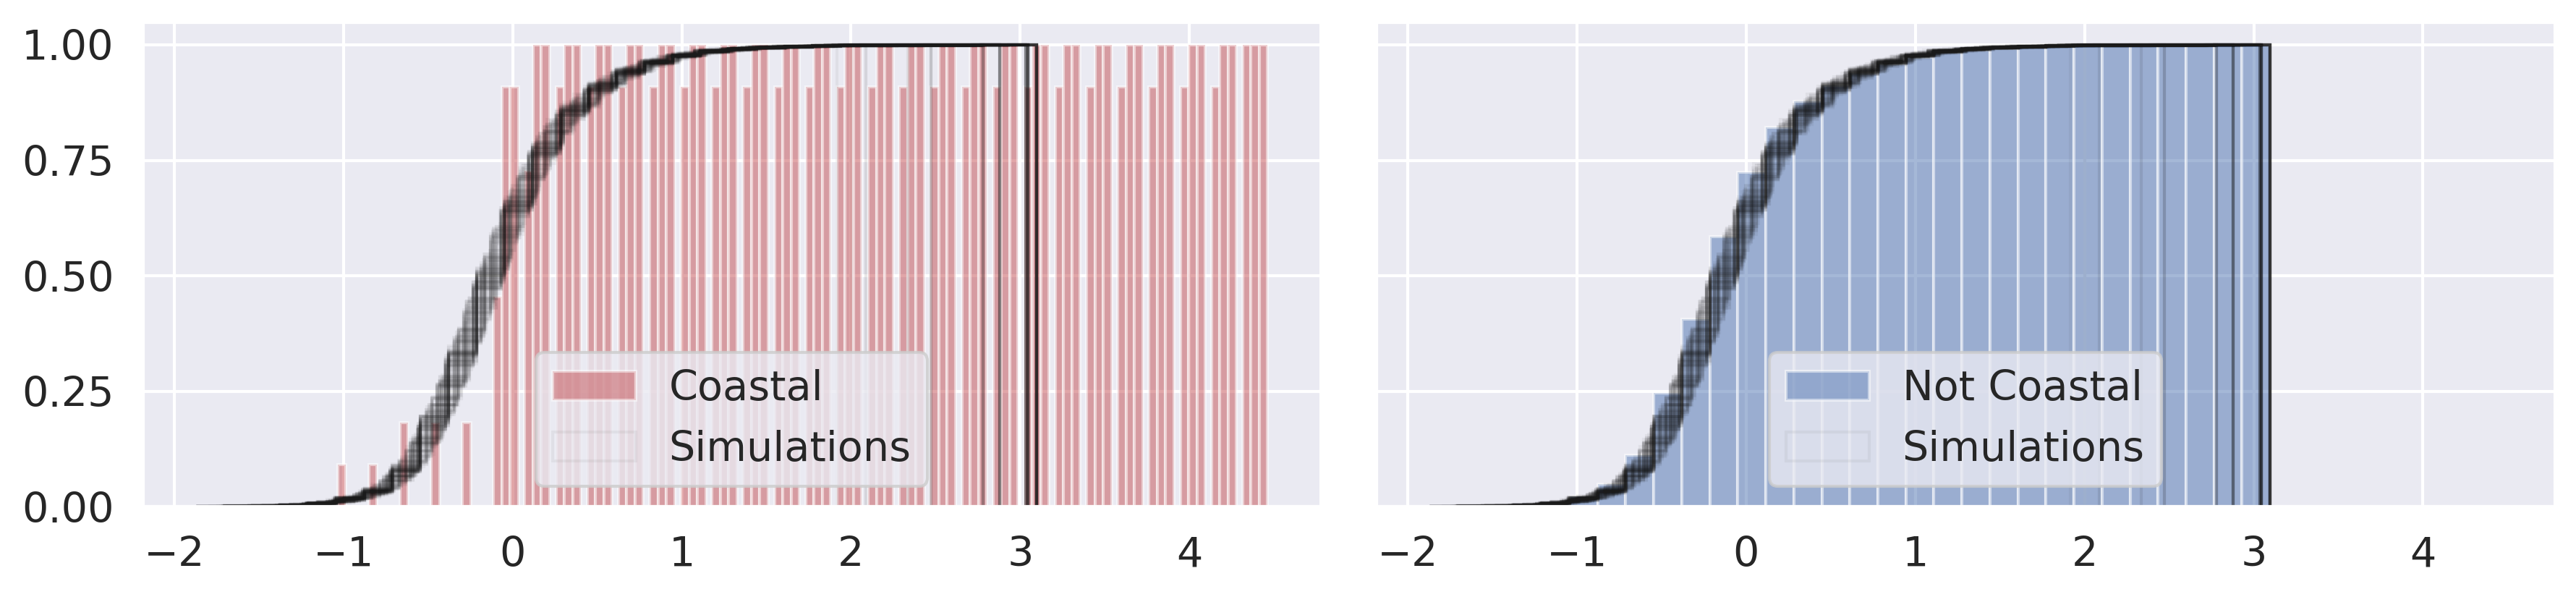

In [50]:
n_simulations = 100
f, ax = plt.subplots(1, 2, figsize=(12, 3), sharex=True, sharey=True)
ax[0].hist(
    coastal,
    color=["r"] * 3,
    alpha=0.5,
    density=True,
    bins=30,
    label="Coastal",
    cumulative=True,
)
ax[1].hist(
    not_coastal,
    color="b",
    alpha=0.5,
    density=True,
    bins=30,
    label="Not Coastal",
    cumulative=True,
)
for simulation in range(n_simulations):
    shuffled_residuals = m1.u[numpy.random.permutation(m1.n)]
    random_coast, random_notcoast = (
        shuffled_residuals[is_coastal],
        shuffled_residuals[~is_coastal],
    )
    if simulation == 0:
        label = "Simulations"
    else:
        label = None
    ax[0].hist(
        random_coast,
        density=True,
        histtype="step",
        color="k",
        alpha=0.05,
        bins=30,
        label=label,
        cumulative=True,
    )
    ax[1].hist(
        random_coast,
        density=True,
        histtype="step",
        color="k",
        alpha=0.05,
        bins=30,
        label=label,
        cumulative=True,
    )
ax[0].legend()
ax[1].legend()
plt.tight_layout()
plt.show()

#### K 邻域相关图

此外，我们的错误预测中的空间依赖性可能只对彼此非常接近的站点有影响，并且会随着距离的增加而迅速衰减。
为了研究这一点，我们可以检查每个站点的残差与第 $k$ 个最近邻居残差的 *平均值* 之间的相关性，增加 $k$ 直到估计值稳定。
这个主要思想是地理统计概念 *相关图* 的核心，它给出了随着距离的增加所研究属性的站点之间的相关性。

检查我们所看到的内容是否 *独特* 或 *重要* 的一个快速方法是将其与我们随机分配邻居时发生的情况进行比较。
如果我们观察到的内容与邻居随机出现时出现的内容有很大不同，那么邻居的结构会在残差中嵌入一个结构。
我们不会花太多时间专门研究这个理论，但我们可以快速有效地计算观察到的残差与增加的 $k$ 个最近邻集的空间滞后之间的相关性：

In [51]:
correlations = []
nulls = []
for order in range(1, 51, 5):
    knn.reweight(
        k=order, inplace=True
    )  # operates in place, quickly and efficiently avoiding copies
    knn.transform = "r"
    lag_residual = weights.spatial_lag.lag_spatial(knn, m1.u)
    random_residual = m1.u[numpy.random.permutation(len(m1.u))]
    random_lag_residual = weights.spatial_lag.lag_spatial(
        knn, random_residual
    )  # identical to random neighbors in KNN
    correlations.append(
        numpy.corrcoef(m1.u.flatten(), lag_residual.flatten())[0, 1]
    )
    nulls.append(
        numpy.corrcoef(m1.u.flatten(), random_lag_residual.flatten())[
            0, 1
        ]
    )

并使用下面的代码生成图XXX9XXX：

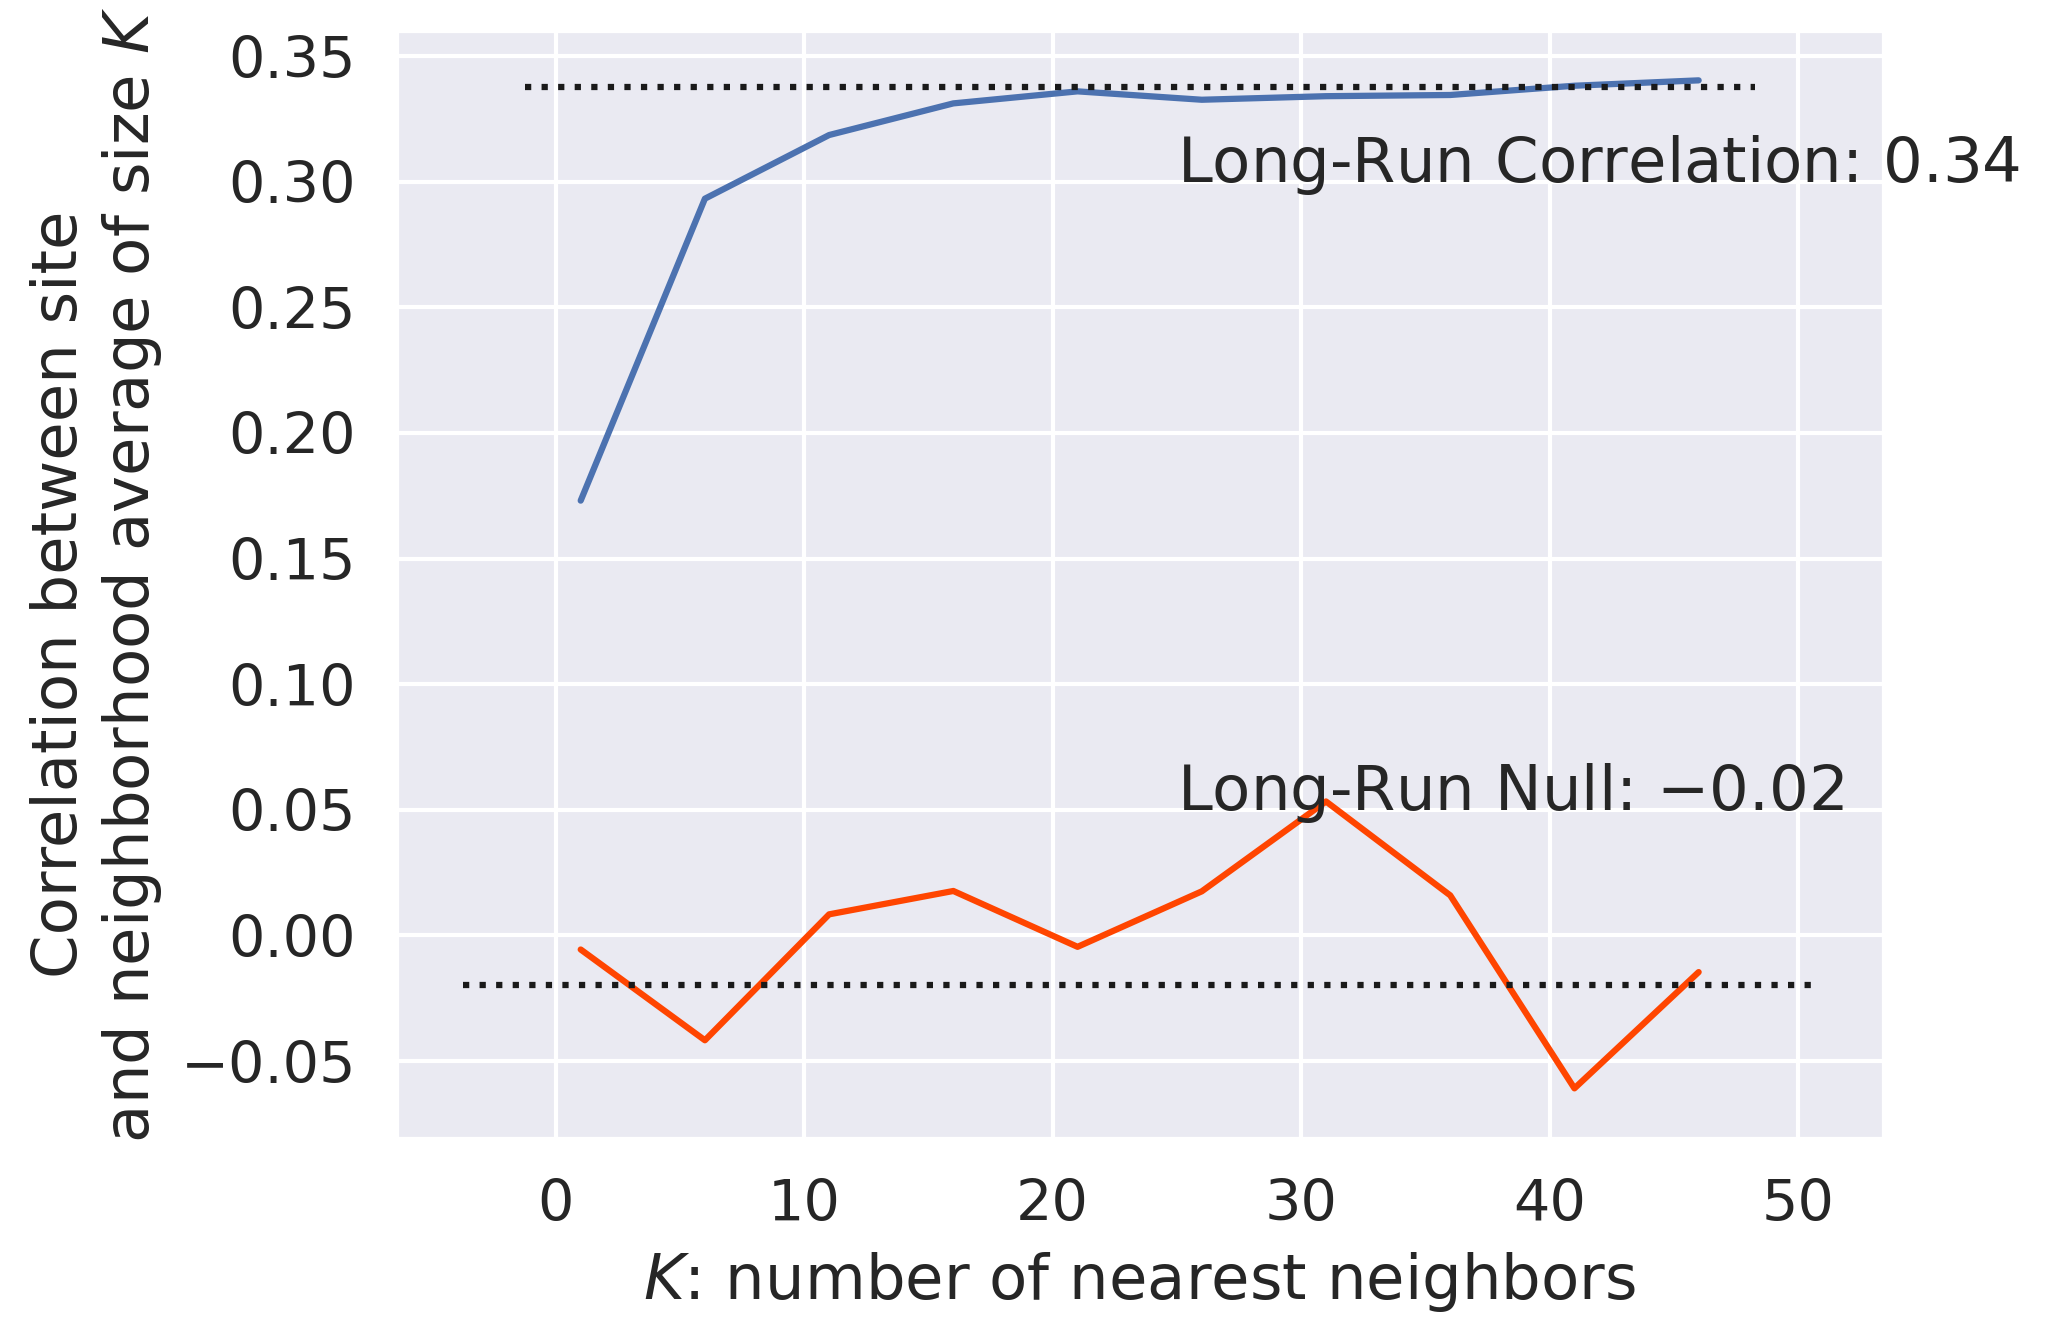

In [52]:
plt.plot(range(1, 51, 5), correlations)
plt.plot(range(1, 51, 5), nulls, color="orangered")
plt.hlines(
    numpy.mean(correlations[-3:]),
    *plt.xlim(),
    linestyle=":",
    color="k"
)
plt.hlines(
    numpy.mean(nulls[-3:]), *plt.xlim(), linestyle=":", color="k"
)
plt.text(
    s="Long-Run Correlation: ${:.2f}$".format(
        numpy.mean(correlations[-3:])
    ),
    x=25,
    y=0.3,
)
plt.text(
    s="Long-Run Null: ${:.2f}$".format(numpy.mean(nulls[-3:])),
    x=25,
    y=0.05,
)
plt.xlabel("$K$: number of nearest neighbors")
plt.ylabel(
    "Correlation between site \n and neighborhood average of size $K$"
)
plt.show()

显然，这两条曲线是不同的。当使用大约 20 个最近的列表时，观察到的相关性在 $r=.34$ 左右达到峰值。这意味着添加超过 20 个最近的邻居不会显著改变残差中的相关性。此外，相关性最低的是单个最近邻居，随着更多邻居添加到列表附近，相关性迅速增加。因此，这意味着残差中似乎存在未测量的空间结构，因为它们在靠近时比在远离时更相似。此外，虽然这里没有显示（因为在计算上它变得难以处理），但随着最近邻居的数量变得非常大（接近数据集中的观测值数量），第 $k$ 个最近邻居的残差的平均值变为零，即残差的全局平均值。这意味着残差与几乎恒定的向量的相关性开始接近零。

然而，零相关性使用随机选择的邻居（没有重新分配）。
因此，由于在这种情况下抽样是真正随机的，每个随机选择的 $k$ 个邻居的平均值通常为零（全局平均值）。
因此，观察到的残差与随机选择的 $k$ 个残差的平均值之间的相关性通常也为零。
因此，增加随机选择的邻居的数量不会显著调整长期平均值零。
综上所述，我们可以得出结论，误差中存在明显的正空间依赖性。
这意味着我们的过度预测和低估可能会聚类。

## 下一步

如需阅读本章所涵盖主题的其他内容，请查阅以下资源：

如需更深入地讨论空间计量经济学的基础知识以及 GUI 和命令行软件中的应用，请查阅：

Anselin, Luc and Sergio Rey. 2014. *Modern Spatial Econometrics in Practice: A Guide to GeoDa, GeoDaSpace, and Pysal.* GeoDa Press. 

For additional mathematical detail and more extensive treatment of space-time models, consult: 

Cressie, Noel and Christopher N. Wikle. 2011. *Statistics for Spatio-Temporal Data*. Singapore: Wiley Press. 

For an alternative perspective on regression and critique of the spatial econometric perspective, consider:

Gibbons, Stephen and Henry G. Overman. 2012. "Mostly Pointless Spatial Econometrics." *Journal of Regional Science* 52: 172-191. 

And for a useful overview of the discussions around multi-level modeling, with references therein to further resources, consider: 

Owen, Gwilym, Richard Harris, and Kelvyn Jones. "Under Examination: Multilevel models, geography and health research." *Progress in Human Geography* 40(3): 394-412. 